In [1]:
import ROOT as rt
from root_numpy import root2array, tree2array
#import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

import pandas as pd
import math

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import seaborn as sns
from scipy.stats import ks_2samp
from scipy import stats
#from xgboost import XGBClassifier
import xgboost as xgb
import random
import optuna

import pickle

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++   -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.24/06


In [2]:
def convert(tree, branches, selection):
    feature = tree2array(tree,
                        #branches = wt_variables + variables + mass_variables,
                        branches = branches,
                        # selection = selections
                        selection = 'passChaHadIso && passNeuHadIso && passdR_gl && passHOverE && H_m>110 && H_m<180'
                        )
    return feature


def convert_ntuple_dataframe(path, filename, treename, branches, selections="H_m>110 && H_m<180"):
    rootfile = rt.TFile.Open(path+filename)
    tree = rootfile.Get(treename)
    np = convert(tree, branches, selections)
    dataframe = pd.DataFrame.from_records(np)
    return dataframe, tree

def compare_train_test(clf,x_train,y_train,z_train,w_train,x_test,y_test,z_test,w_test, bins=50, label=''):
    
    # K-S Test
    y_test_pred = clf.predict_proba(x_test)[:, 1]
    y_train_pred = clf.predict_proba(x_train)[:, 1]
    
    y_test_frame = pd.DataFrame({'truth':z_test, 'disc':y_test_pred, 'label':y_test})
    y_train_frame = pd.DataFrame({'truth':z_train, 'disc':y_train_pred, 'label':y_train})

    disc_train_signal_all = y_train_frame[y_train_frame['truth'] < 0]['disc'].values
    disc_train_bkg_all = y_train_frame[y_train_frame['truth'] > 0]['disc'].values

    disc_test_signal_all = y_test_frame[y_test_frame['truth'] < 0]['disc'].values
    disc_test_bkg_all = y_test_frame[y_test_frame['truth'] > 0]['disc'].values

    # K-S test
    stat_signal,pval_signal = ks_2samp(disc_train_signal_all,disc_test_signal_all)
    stat_bkg,pval_bkg = ks_2samp(disc_train_bkg_all,disc_test_bkg_all)
    ######################
    
    
    fig = plt.figure(figsize=(5,5))
    plt.title(label)
    decisions = []
    weight    = []
    print(clf)
    for x,y,w in ((x_train, y_train, w_train), (x_test, y_test, w_test)):
        print(x.shape)
        d1 = clf.predict_proba(x[y>0.5])[:,1]
        d2 = clf.predict_proba(x[y<0.5])[:,1].ravel()
        #d1 = evaluate_sklearn(clf,x[y>0.5])
        #d2 = evaluate_sklearn(clf,x[y<0.5])
        w1 = w[y>0.5]
        w2 = w[y<0.5]
        decisions += [d1, d2]
        weight    += [w1, w2]
        
    low  = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    
    plt.hist(0,
             color='w', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True, 
             label='Sig (Bkg) K-S test p-value: {0:.2f}({1:.2f})'.format(pval_signal, pval_bkg))
    
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             weights = weight[0], 
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             weights = weight[1], 
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True, weights = weight[2] )
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='.', c='r', label='S (test)', markersize=8,capthick=0)
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True, weights = weight[3])
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='.', c='b', label='B (test)', markersize=8,capthick=0)

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    #plt.yscale('log')
    plt.legend(loc='best')
    plt.ylim([0.01, 2*max(hist)])
    #plt.savefig('./plot/BDT_output.png',dpi=300)
    plt.show()
    

In [3]:
# Za variables
# 1. pho1Pt: Leading photon’s pT ;
# 2. pho1R9: Leading photon’s R9;
# 3. pho1IetaIeta55: Leading photon’s σietaieta5×5;
# 4. pho1PIso noCorr: Leading photon’s PF Photon Isolation; 
# 5. pho2Pt: Sub-leading photon’s pT ;
# 6. pho2R9: Sub-leading photon’s R9;
# 7. pho2IetaIeta55: Sub-leading photon’s σietaieta5×5;
# 8. pho2PIso noCorr: Sub-leading photon’s PF Photon Isolation;
# 9. ALP calculatedPhotonIso: Firstly, we combine two selected photons together as one single object. Than, we calculate the PF Photon Isolation for this combined object as ALPs photon isolation.
# 10. var dR Za: ∆R between Z and diphoton pair (∆R(Z, a)); 
# 11. var dR g1g2: ∆R between two photons (∆R(γ1, γ2));
# 12. var dR g1Z: ∆R between leading photon and Z (∆R(γ1, Z));
# 13. var PtaOverMh: pTa / mH
# 14. Hpt: HpT;
# 15. (m_a - m_a, hype) / mH

variables = ["pho1Pt", "pho1R9", "pho1IetaIeta55", "pho1PIso_noCorr", "pho2Pt", "pho2R9", "pho2IetaIeta55", "pho2PIso_noCorr", "ALP_calculatedPhotonIso", "var_dR_Za", "var_dR_g1g2", "var_dR_g1Z", "var_PtaOverMh", "H_pt"]
mass_variables = ["ALP_m", "H_m"]
wt_variables = ['factor*pho1SFs*pho2SFs']

file_path = "/afs/cern.ch/work/p/pelai/HZa/ALP/Analysis_code/train_MVA/skimmed_ntuples"
bkg_name = ['DYJets']
data_name = ['data']
sig_name = ['sig']
mass_list = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 15., 20., 25., 30.]

years = ['run2']
tree_name = "passedEvents"

dfs = {}
tree = {}
for year in years:
    dfs[year] = {}
    tree[year] = {}
    for dataset in bkg_name + data_name:
        dfs[year][dataset], tree[year][dataset] = convert_ntuple_dataframe("{}/{}/".format(file_path,dataset),"{}_{}.root".format(tree_name, year), tree_name, variables+mass_variables+wt_variables, selections="H_m>110 && H_m<180")
        dfs[year][dataset]['mass'] = list(random.choice(mass_list) for _ in range(dfs[year][dataset].shape[0]))
        dfs[year][dataset]['param'] = (dfs[year][dataset]['ALP_m'] - dfs[year][dataset]['mass']) / dfs[year][dataset]['H_m']

    for dataset in sig_name:
        dfs[year][dataset] = {}
        tree[year][dataset] = {}
        for mass in mass_list:
            dfs[year][dataset][mass], tree[year][dataset][mass] = convert_ntuple_dataframe("{}/{}/".format(file_path, dataset), 'ALP_M'+str(int(mass))+'.root', tree_name, variables+mass_variables+wt_variables, selections="H_m>110 && H_m<180")
            dfs[year][dataset][mass]["mass"] = mass
            dfs[year][dataset][mass]['param'] = (dfs[year][dataset][mass]['ALP_m'] - dfs[year][dataset][mass]['mass']) / dfs[year][dataset][mass]['H_m']
            # dfs[year][dataset]['factor'] = dfs[year][dataset]['factor'] * dfs[year][dataset]['pho1SFs'] * dfs[year][dataset]['pho2SFs'] 



df_bkg_dy   = pd.concat([dfs[y]["DYJets"] for y in years])
df_bkg_all  = pd.concat([dfs[y][bkg] for y in years for bkg in bkg_name ])

df_sig_a    = pd.concat([dfs[y]["sig"][m] for y in years for m in mass_list])
df_sig_all  = pd.concat([dfs[y][sig][m] for y in years for sig in sig_name for m in mass_list])

df_data_all = pd.concat([dfs[y][dataset] for y in years for dataset in data_name])


Error in <TList::Clear>: A list is accessing an object (0x7f5ff50) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa7469a0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa746dd0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa74ea80) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa74edf0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa74f160) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa74f690) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa74fa50) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa7503b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xa752910) alread

In [4]:
[df_sig_all['mass']]

[0         1.0
 1         1.0
 2         1.0
 3         1.0
 4         1.0
          ... 
 24122    30.0
 24123    30.0
 24124    30.0
 24125    30.0
 24126    30.0
 Name: mass, Length: 245591, dtype: float64]

Get sideband/signal region data

In [5]:
# sideband 95 <𝑚𝓁𝓁γγ <115 GeV and 135 <𝑚𝓁𝓁γγ <180 GeV)
data_SB = df_data_all[( (df_data_all["H_m"] > 110) & (df_data_all["H_m"] < 115) ) | ( (df_data_all["H_m"] > 135) & (df_data_all["H_m"] < 180) )]
bkg_SB = df_bkg_all[( (df_bkg_all["H_m"] > 110) & (df_bkg_all["H_m"] < 115) ) | ( (df_bkg_all["H_m"] > 135) & (df_bkg_all["H_m"] < 180) )]

wt_var_indices = [df_sig_all.columns.get_loc(v) for v in wt_variables]

n_data_SB = np.sum(data_SB.values[:,wt_var_indices])
n_bkg_SB = np.sum(bkg_SB.values[:,wt_var_indices])
print("weighted Sideband event: data", n_data_SB, "bkg:", n_bkg_SB)

weighted Sideband event: data 22244.0 bkg: 21004.606967787506


pho1Pt
$\gamma_{Leading} \ P_{T}$


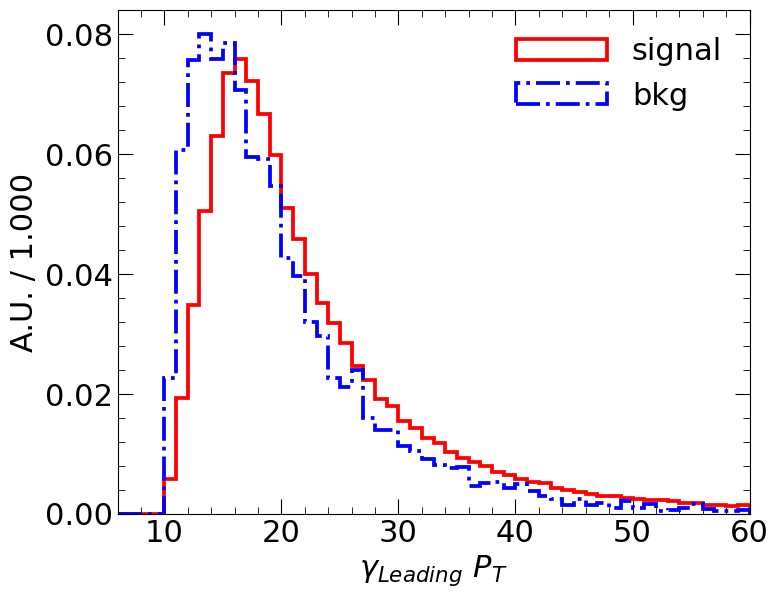

pho1R9
$\gamma_{Leading}$ R9


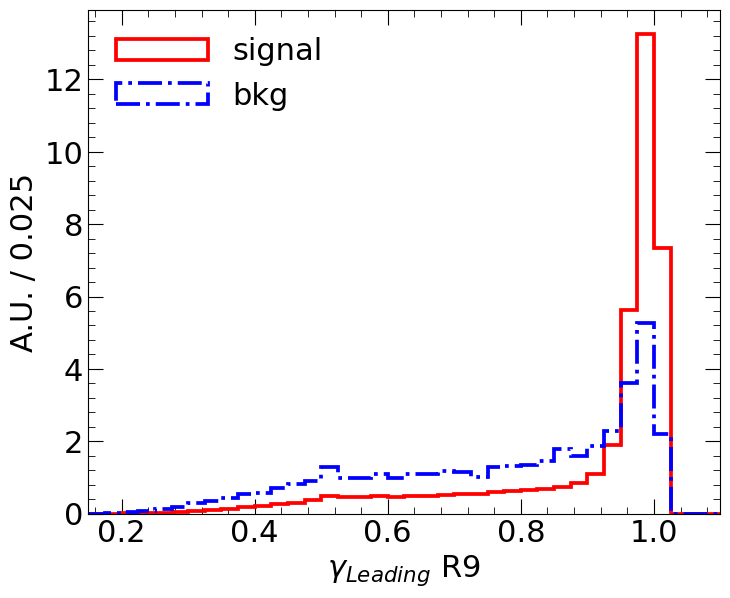

pho1IetaIeta55
$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$


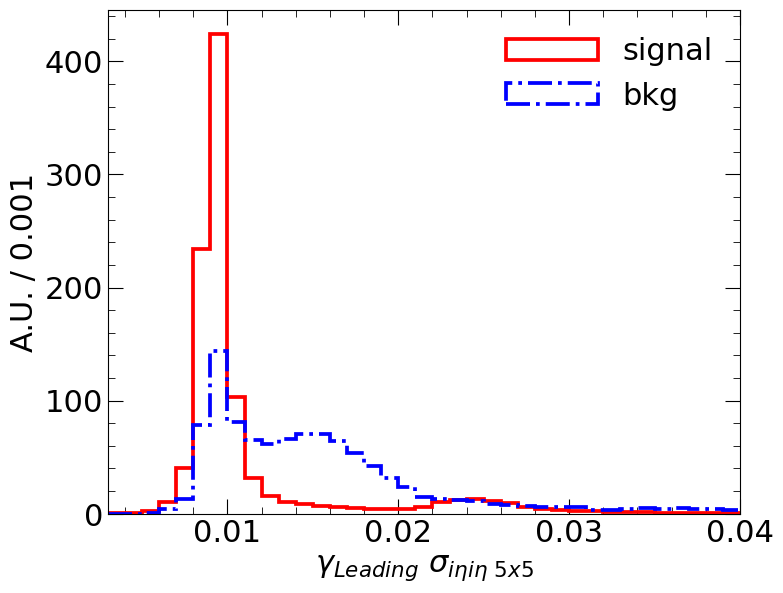

pho1PIso_noCorr
 $\gamma_{Leading}$ $PF_{\gamma}$ Iso


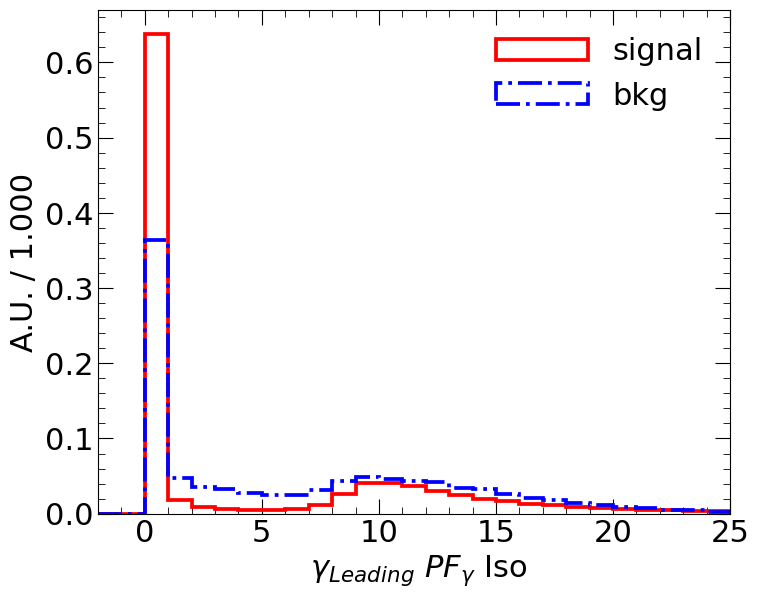

pho2Pt
$\gamma_{Subleading} \ P_{T}$


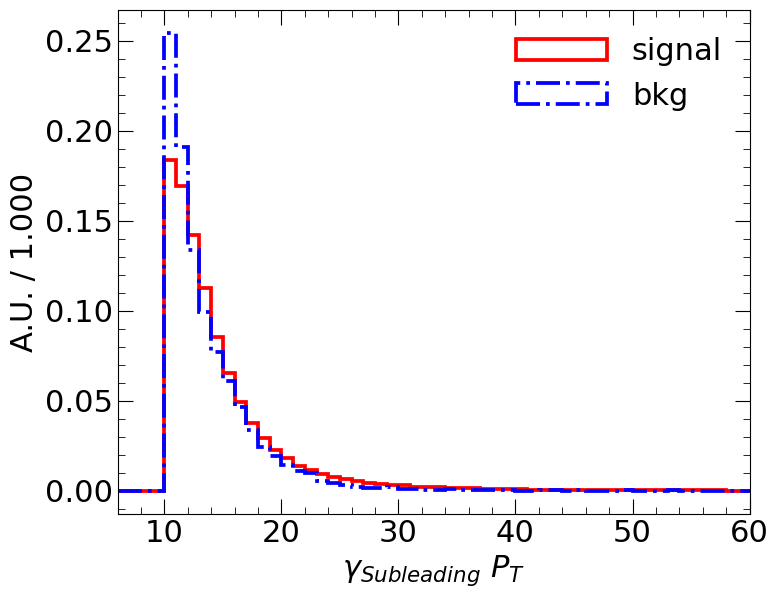

pho2R9
$\gamma_{Subleading}$ R9


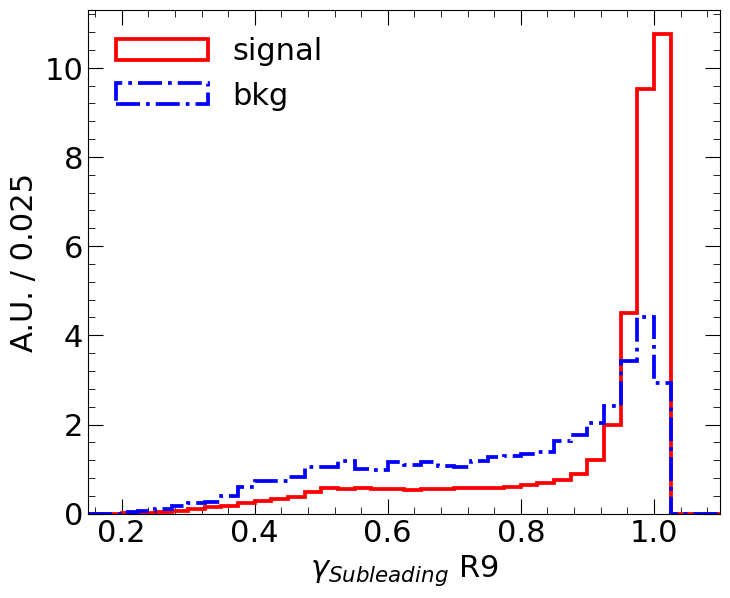

pho2IetaIeta55
$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$


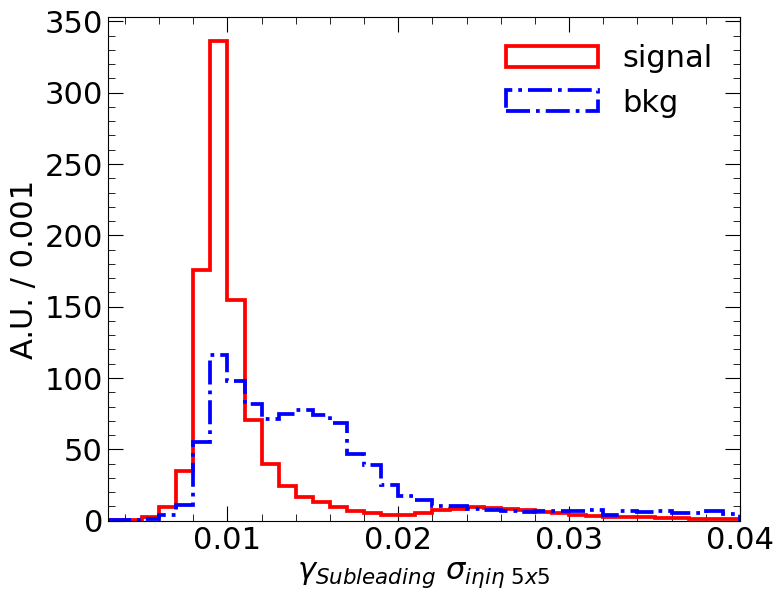

pho2PIso_noCorr
$\gamma_{Subleading}$ $PF_{\gamma}$ Iso


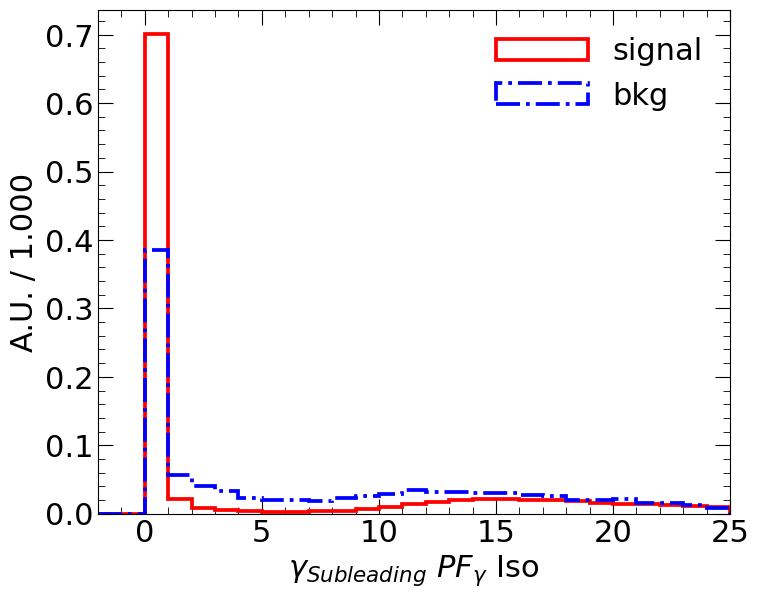

ALP_calculatedPhotonIso
$\gamma\gamma$ Iso


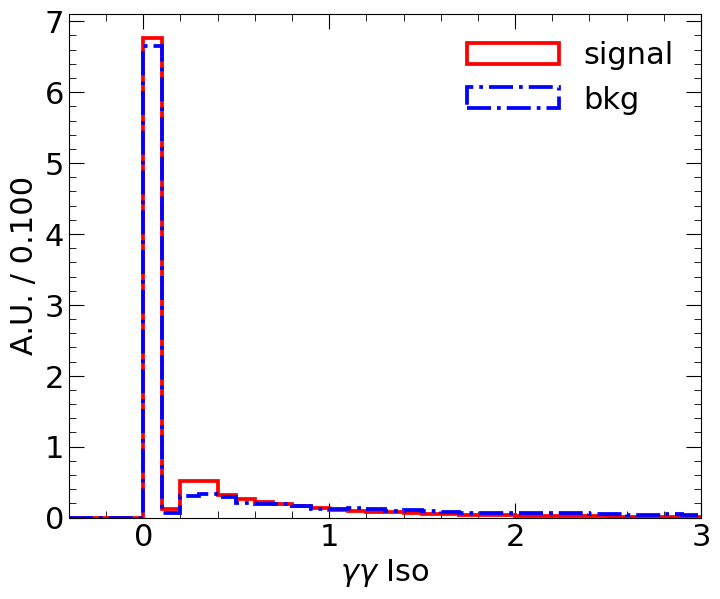

var_dR_Za
$\Delta R(Z,a)$


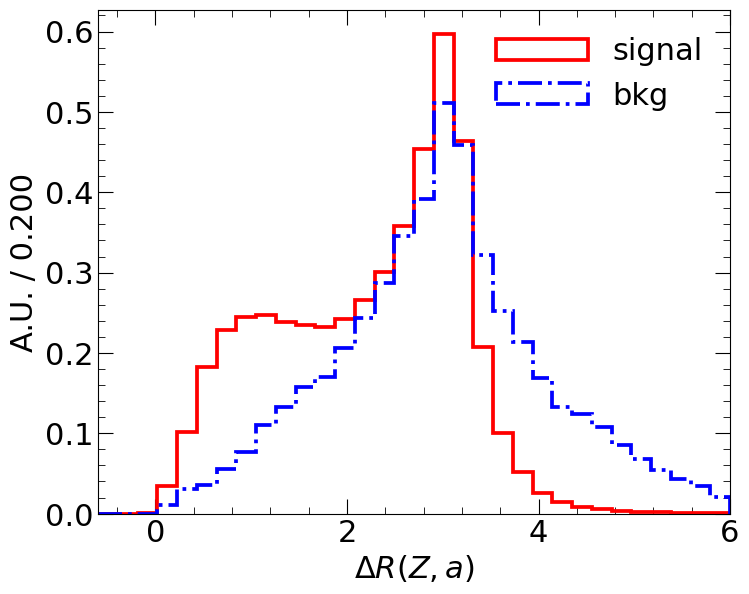

var_dR_g1g2
$\Delta R(\gamma,\gamma)$


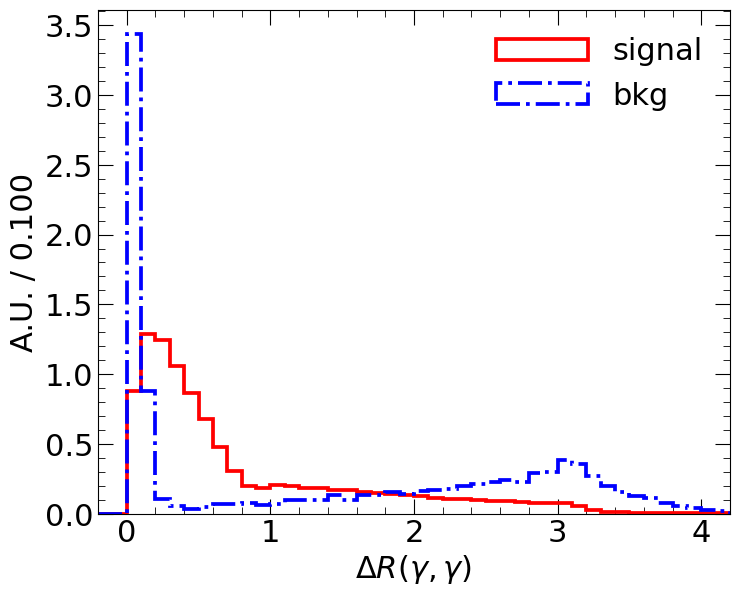

var_dR_g1Z
$\Delta R(\gamma_{Leading}, Z)$


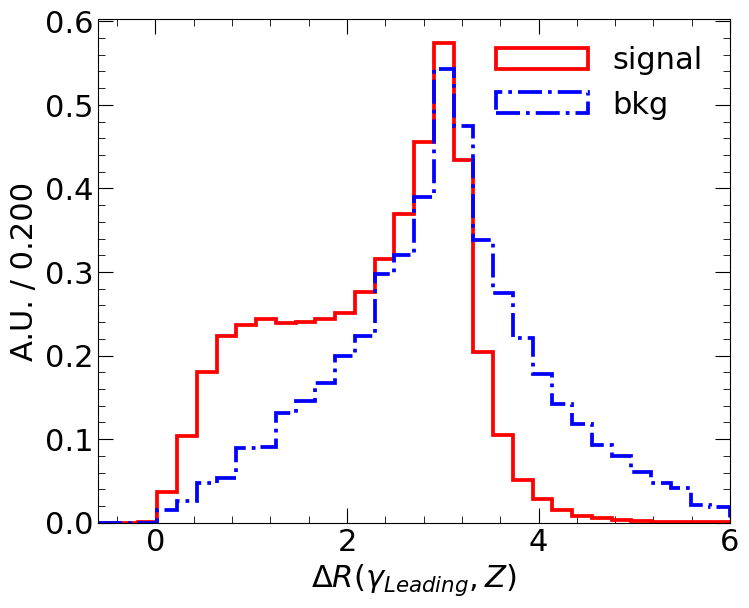

var_PtaOverMh
$P_{t,a} / m_{H}$


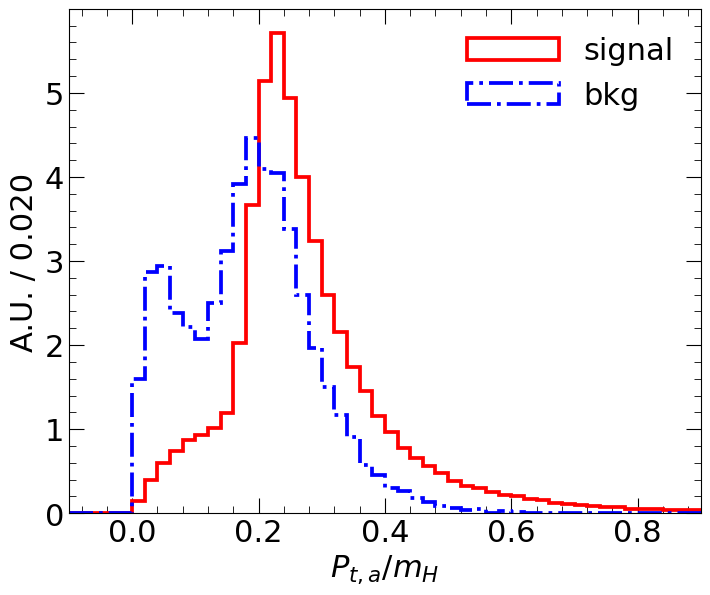

H_pt
$P_{T,H}$


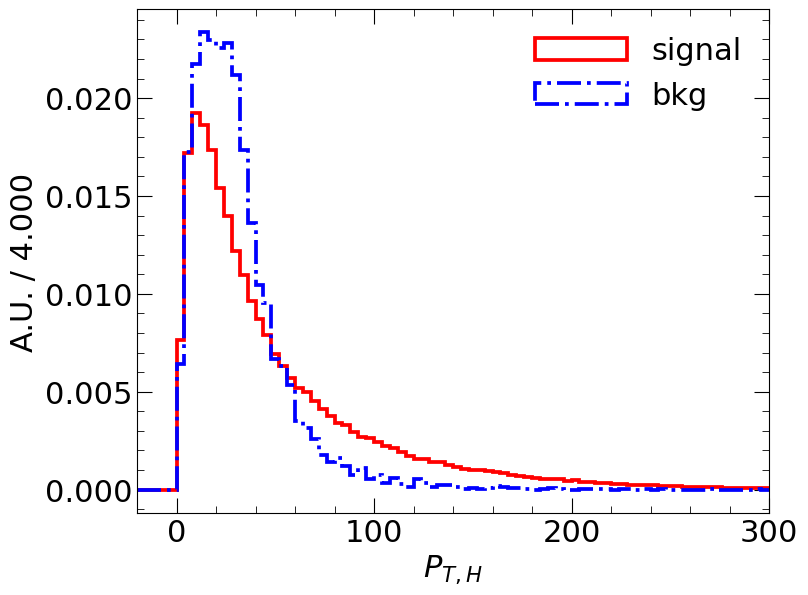

param
$(m_{a} - m_{a, hype}) / m_{H}$


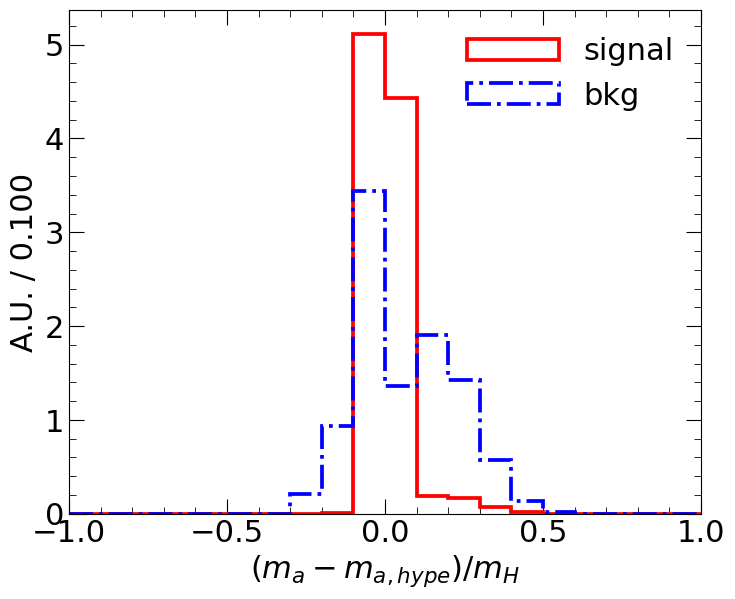

ALP_m
$m_{a}$


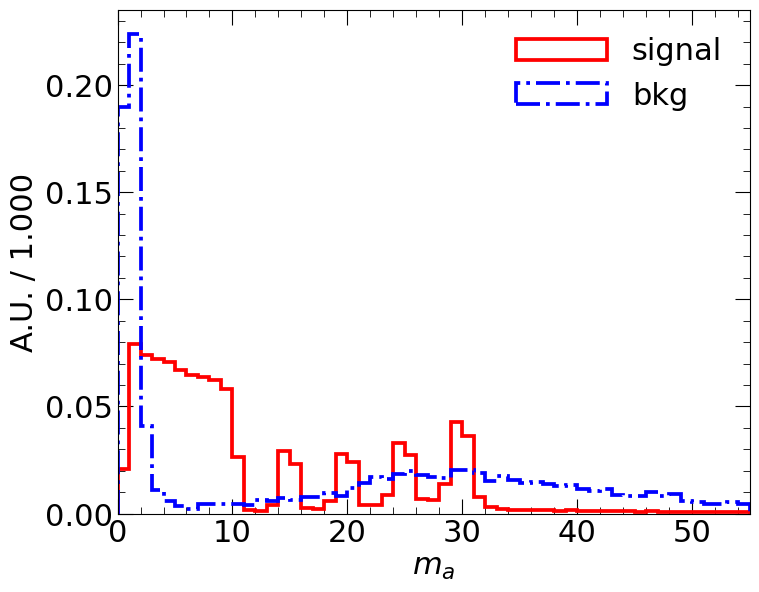

H_m
$m_{H}$


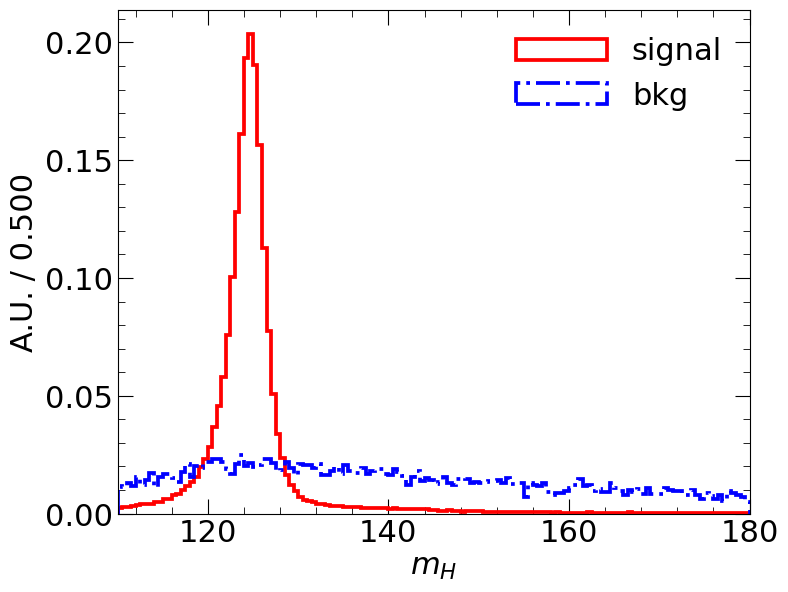

In [6]:
file_name = ["pho1Pt", "pho1R9", "pho1IetaIeta55", "pho1PIso_noCorr", "pho2Pt", "pho2R9", "pho2IetaIeta55", "pho2PIso_noCorr", "ALP_calculatedPhotonIso", "var_dR_Za", "var_dR_g1g2", "var_dR_g1Z", "var_PtaOverMh", "H_pt", "param", "ALP_m", "H_m"]

xlabel = ["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{a}$", "$m_{H}$"]

x_limits = {
    'pho1Pt': (6, 60),
    'pho1R9': (0.15, 1.1),
    'pho1IetaIeta55': (0.003, 0.04),
    'pho1PIso_noCorr': (-2, 25),
    'pho2Pt': (6, 60),
    'pho2R9': (0.15, 1.1),
    'pho2IetaIeta55': (0.003, 0.04),
    'pho2PIso_noCorr': (-2, 25),
    'ALP_calculatedPhotonIso': (-0.4,3),
    'var_dR_Za':(-0.6, 6),
    'var_dR_g1g2':(-0.2, 4.2),
    'var_dR_g1Z':(-0.6, 6),
    'var_PtaOverMh':(-0.1, 0.9),
    'H_pt':(-20, 300),
    'param':(-1, 1),
    'ALP_m':(0, 55),    
    'H_m':(110, 180),
}

bin_sizes = {
    'pho1Pt': 1,
    'pho1R9': 0.025,
    'pho1IetaIeta55': 0.001,
    'pho1PIso_noCorr': 1.,
    'pho2Pt': 1,
    'pho2R9': 0.025,
    'pho2IetaIeta55': 0.001,
    'pho2PIso_noCorr': 1.,
    'ALP_calculatedPhotonIso': 0.1,
    'var_dR_Za': 0.2,
    'var_dR_g1g2': 0.1,
    'var_dR_g1Z': 0.2,
    'var_PtaOverMh': 0.02,
    'H_pt': 4,
    'param': 0.1,
    'ALP_m': 1,    
    'H_m': 0.5,
}

for hlf, xlabel_hlf, fn in zip(variables+['param']+mass_variables, xlabel, file_name):
    print(hlf)
    print(xlabel_hlf)
    
    plt.figure(figsize=(8, 6))

    x_min, x_max = x_limits.get(hlf)

    data_range = x_max - x_min
    bin_size = bin_sizes.get(hlf, data_range/40.)
    num_bins = int(data_range / float(bin_size))  # Ensure float division

    bins = np.linspace(x_min, x_max, num_bins + 1)

    plt.hist(df_sig_all[hlf], weights=df_sig_all['factor*pho1SFs*pho2SFs'], bins=bins, density=True, histtype='step', label='signal', color='red', linestyle='-', linewidth=2.7)
    plt.hist(df_bkg_all[hlf], weights=df_bkg_all['factor*pho1SFs*pho2SFs'], bins=bins, density=True, histtype='step', label='bkg', color='blue', linestyle='-.', linewidth=2.7)
    
    plt.xlabel(xlabel_hlf, fontsize=22)
    plt.ylabel(f'A.U. / {bin_size:.3f}', fontsize=22)  # Include the bin size in the y-axis label

    if hlf in x_limits:
        plt.xlim(x_limits[hlf])  # Set the x-axis range based on the limits for the current variable
    

    plt.tick_params(axis='x', labelsize=22, direction='in', top=True, right=True, length=11)  # Set the font size of the x-axis tick labels
    plt.tick_params(axis='y', labelsize=22, direction='in', top=True, right=True, length=11)  # Set the font size of the y-axis tick labels

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))  # Set the same number of sub-ticks between the major ticks
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5))  # Set the same number of sub-ticks between the major ticks
    plt.gca().tick_params(which='minor', direction='in', top=True, right=True, length=5)  # Set the direction of the sub-ticks to 'in' for top and right sides

    plt.subplots_adjust(left=0.17, right=0.96, top=0.97, bottom=0.13)

    plt.legend(loc='best', frameon=False, handlelength=3.0, fontsize=22)
    plt.savefig(f'./train_MVA_Fig/{fn}.pdf', format='pdf')
    plt.show()
    


['pho1Pt', 'pho1R9', 'pho1IetaIeta55', 'pho1PIso_noCorr', 'pho2Pt', 'pho2R9', 'pho2IetaIeta55', 'pho2PIso_noCorr', 'ALP_calculatedPhotonIso', 'var_dR_Za', 'var_dR_g1g2', 'var_dR_g1Z', 'var_PtaOverMh', 'H_pt']
          pho1Pt    pho1R9  pho1IetaIeta55  pho1PIso_noCorr     pho2Pt  \
0      21.474161  0.989749        0.010457        10.342197  11.651003   
1      17.520979  1.000000        0.010092        13.192146  15.932410   
2      13.557652  1.000000        0.008958        13.270945  13.502235   
3      13.278548  1.000000        0.009415         8.736761  10.137753   
4      20.938280  0.938059        0.009289         8.602489  11.017659   
...          ...       ...             ...              ...        ...   
24122  17.430346  0.941109        0.009749         0.000000  10.919184   
24123  17.130619  0.964673        0.009339         0.000000  12.676810   
24124  22.258013  0.985004        0.009232         0.000000  11.399495   
24125  18.766027  0.988678        0.009420         

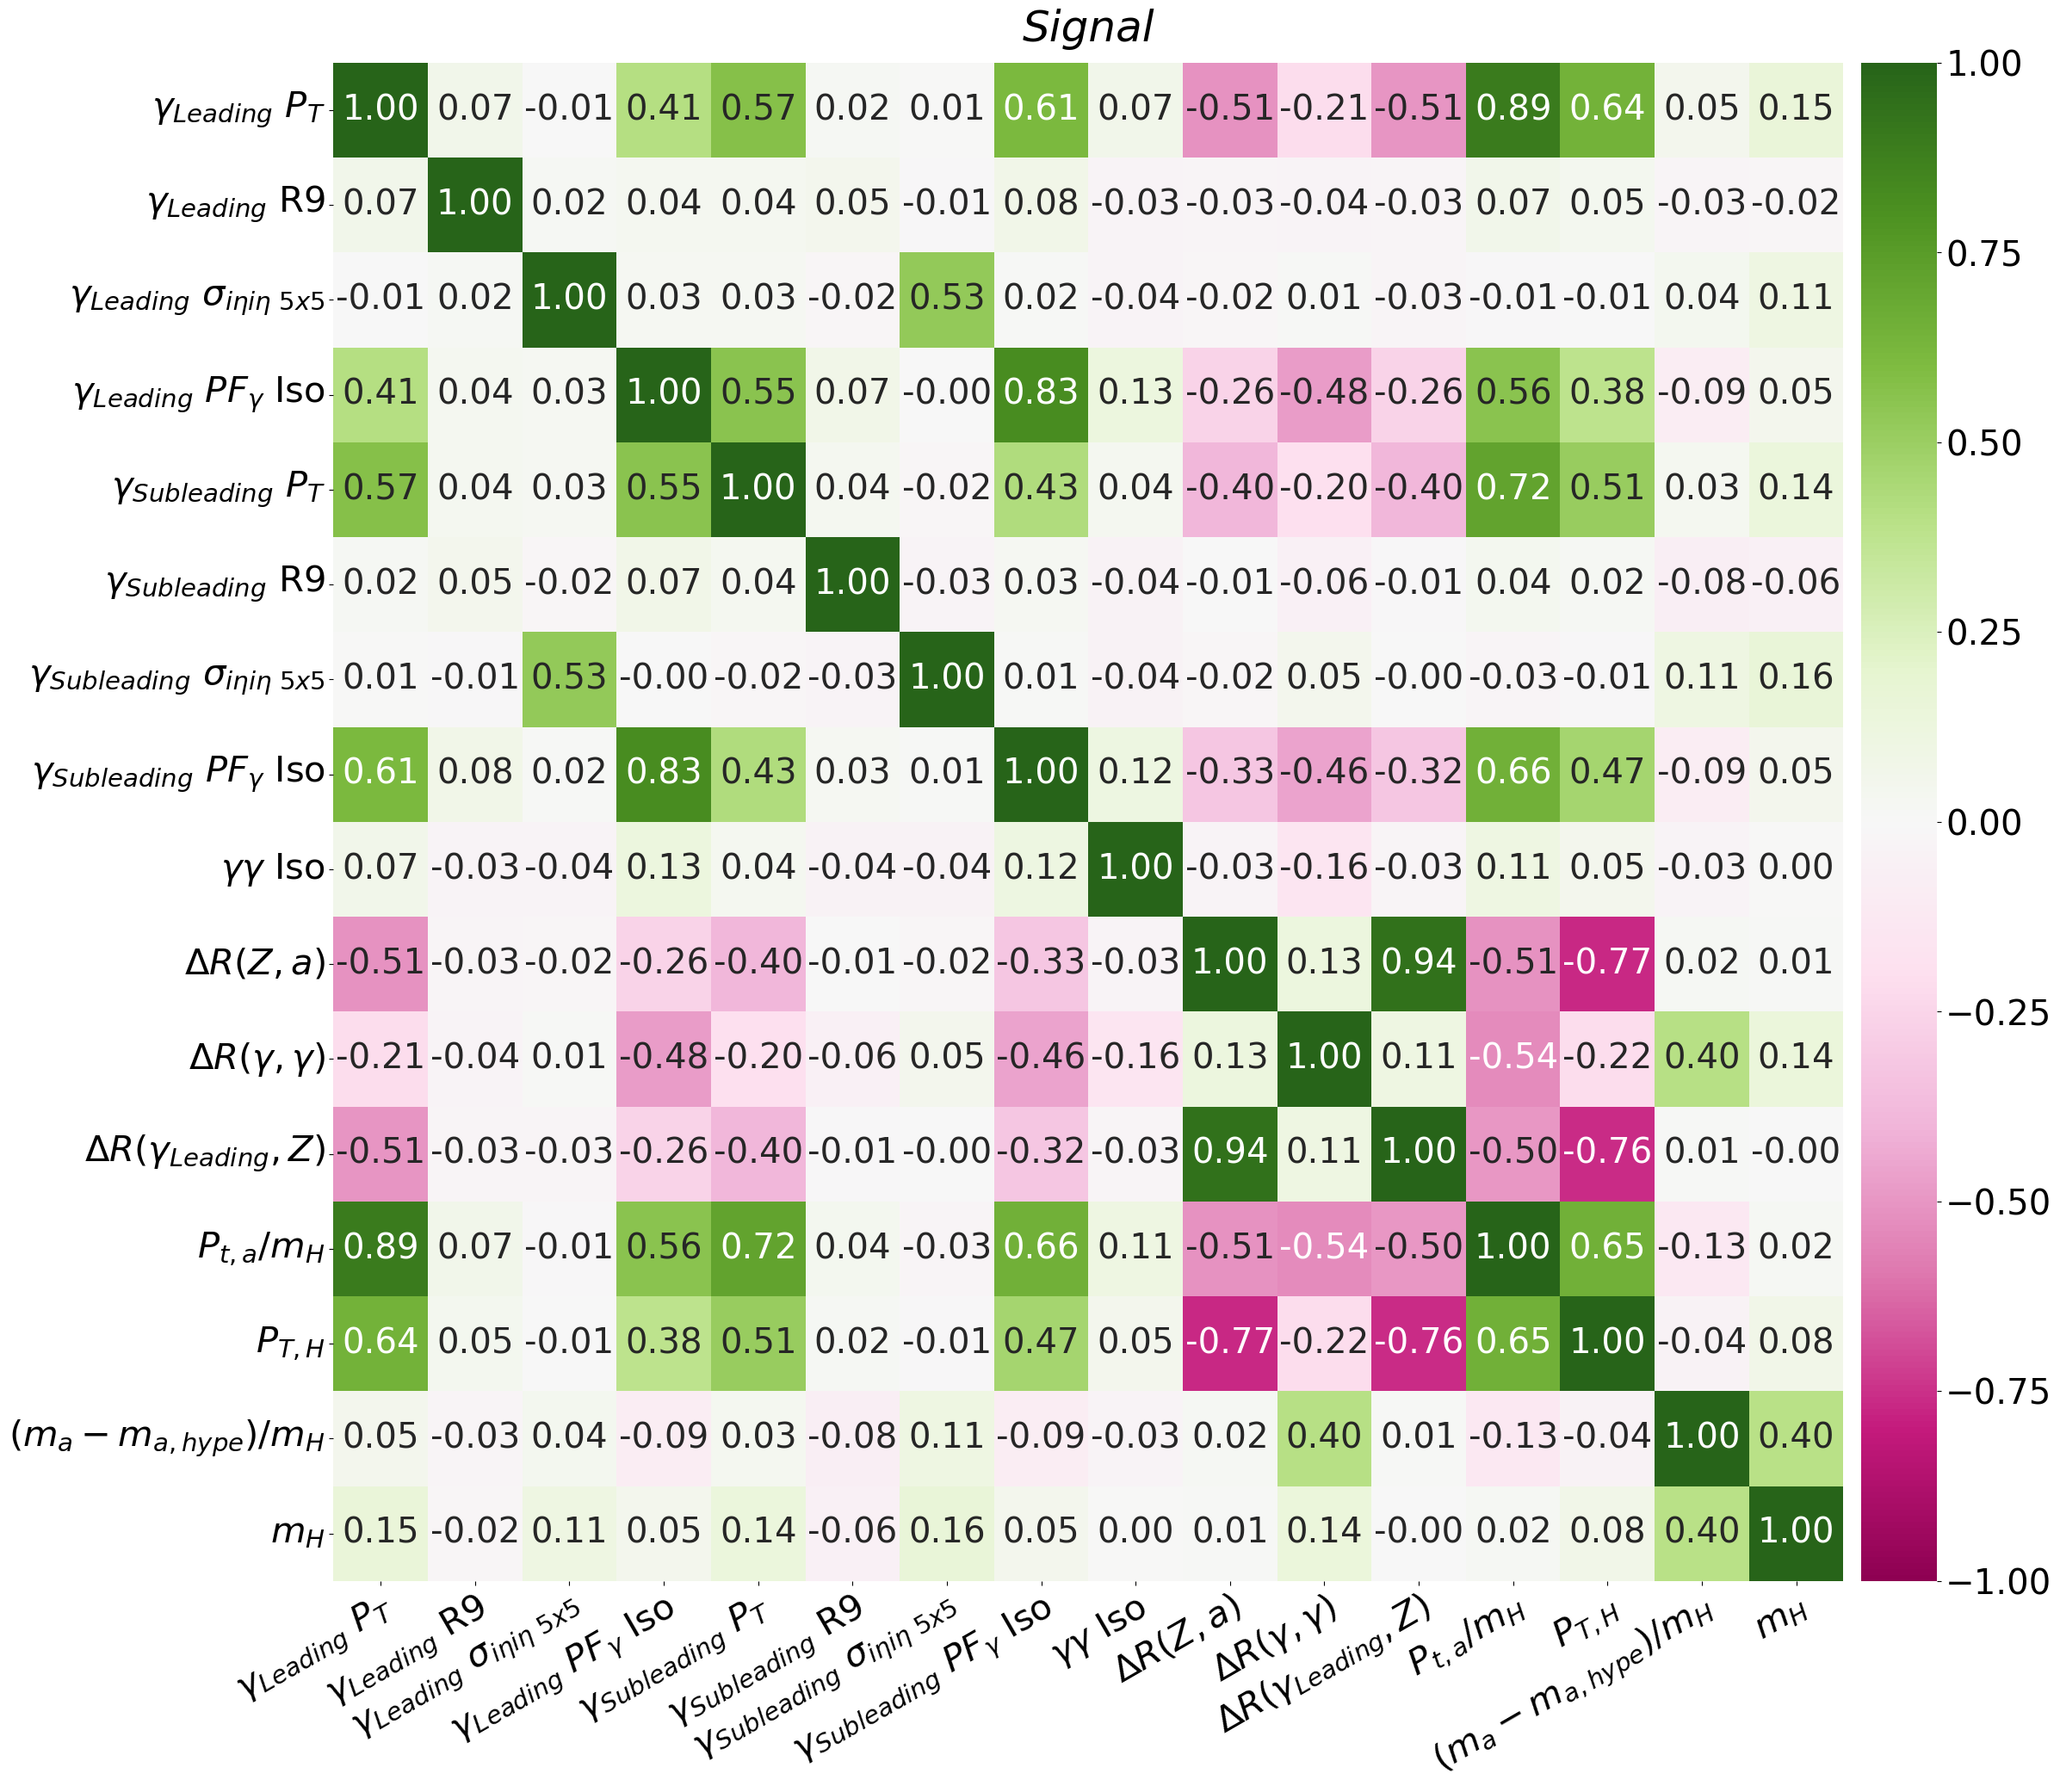

In [7]:
print(variables)

plt.figure(figsize=(24, 21))
ax1 = plt.gca()
# Signal heatmap

print(df_sig_all[variables+["param"]+["H_m"]])

cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(df_sig_all[variables+["param"]+["H_m"]].corr(), annot=True, fmt=".2f", ax = ax1, cmap="PiYG", annot_kws={"size": 29}, cbar_kws={'pad': 0.01}, vmin=-1, vmax=1)
ax1.set_title('Signal', fontsize=36, fontstyle='italic', pad=18)
ax1.tick_params(axis='both', which='major', labelsize=30)

# Adjust z-axis (colorbar) label size
cbar1 = ax1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=29)

ax1.set_xticklabels(["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{H}$"])
ax1.set_yticklabels(["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{H}$"])


ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right', rotation_mode="anchor")

plt.subplots_adjust(left=0.16, right=1.03, top=0.95, bottom=0.11)

plt.savefig('./train_MVA_Fig/corr_Sig.pdf', format='pdf')

['pho1Pt', 'pho1R9', 'pho1IetaIeta55', 'pho1PIso_noCorr', 'pho2Pt', 'pho2R9', 'pho2IetaIeta55', 'pho2PIso_noCorr', 'ALP_calculatedPhotonIso', 'var_dR_Za', 'var_dR_g1g2', 'var_dR_g1Z', 'var_PtaOverMh', 'H_pt']


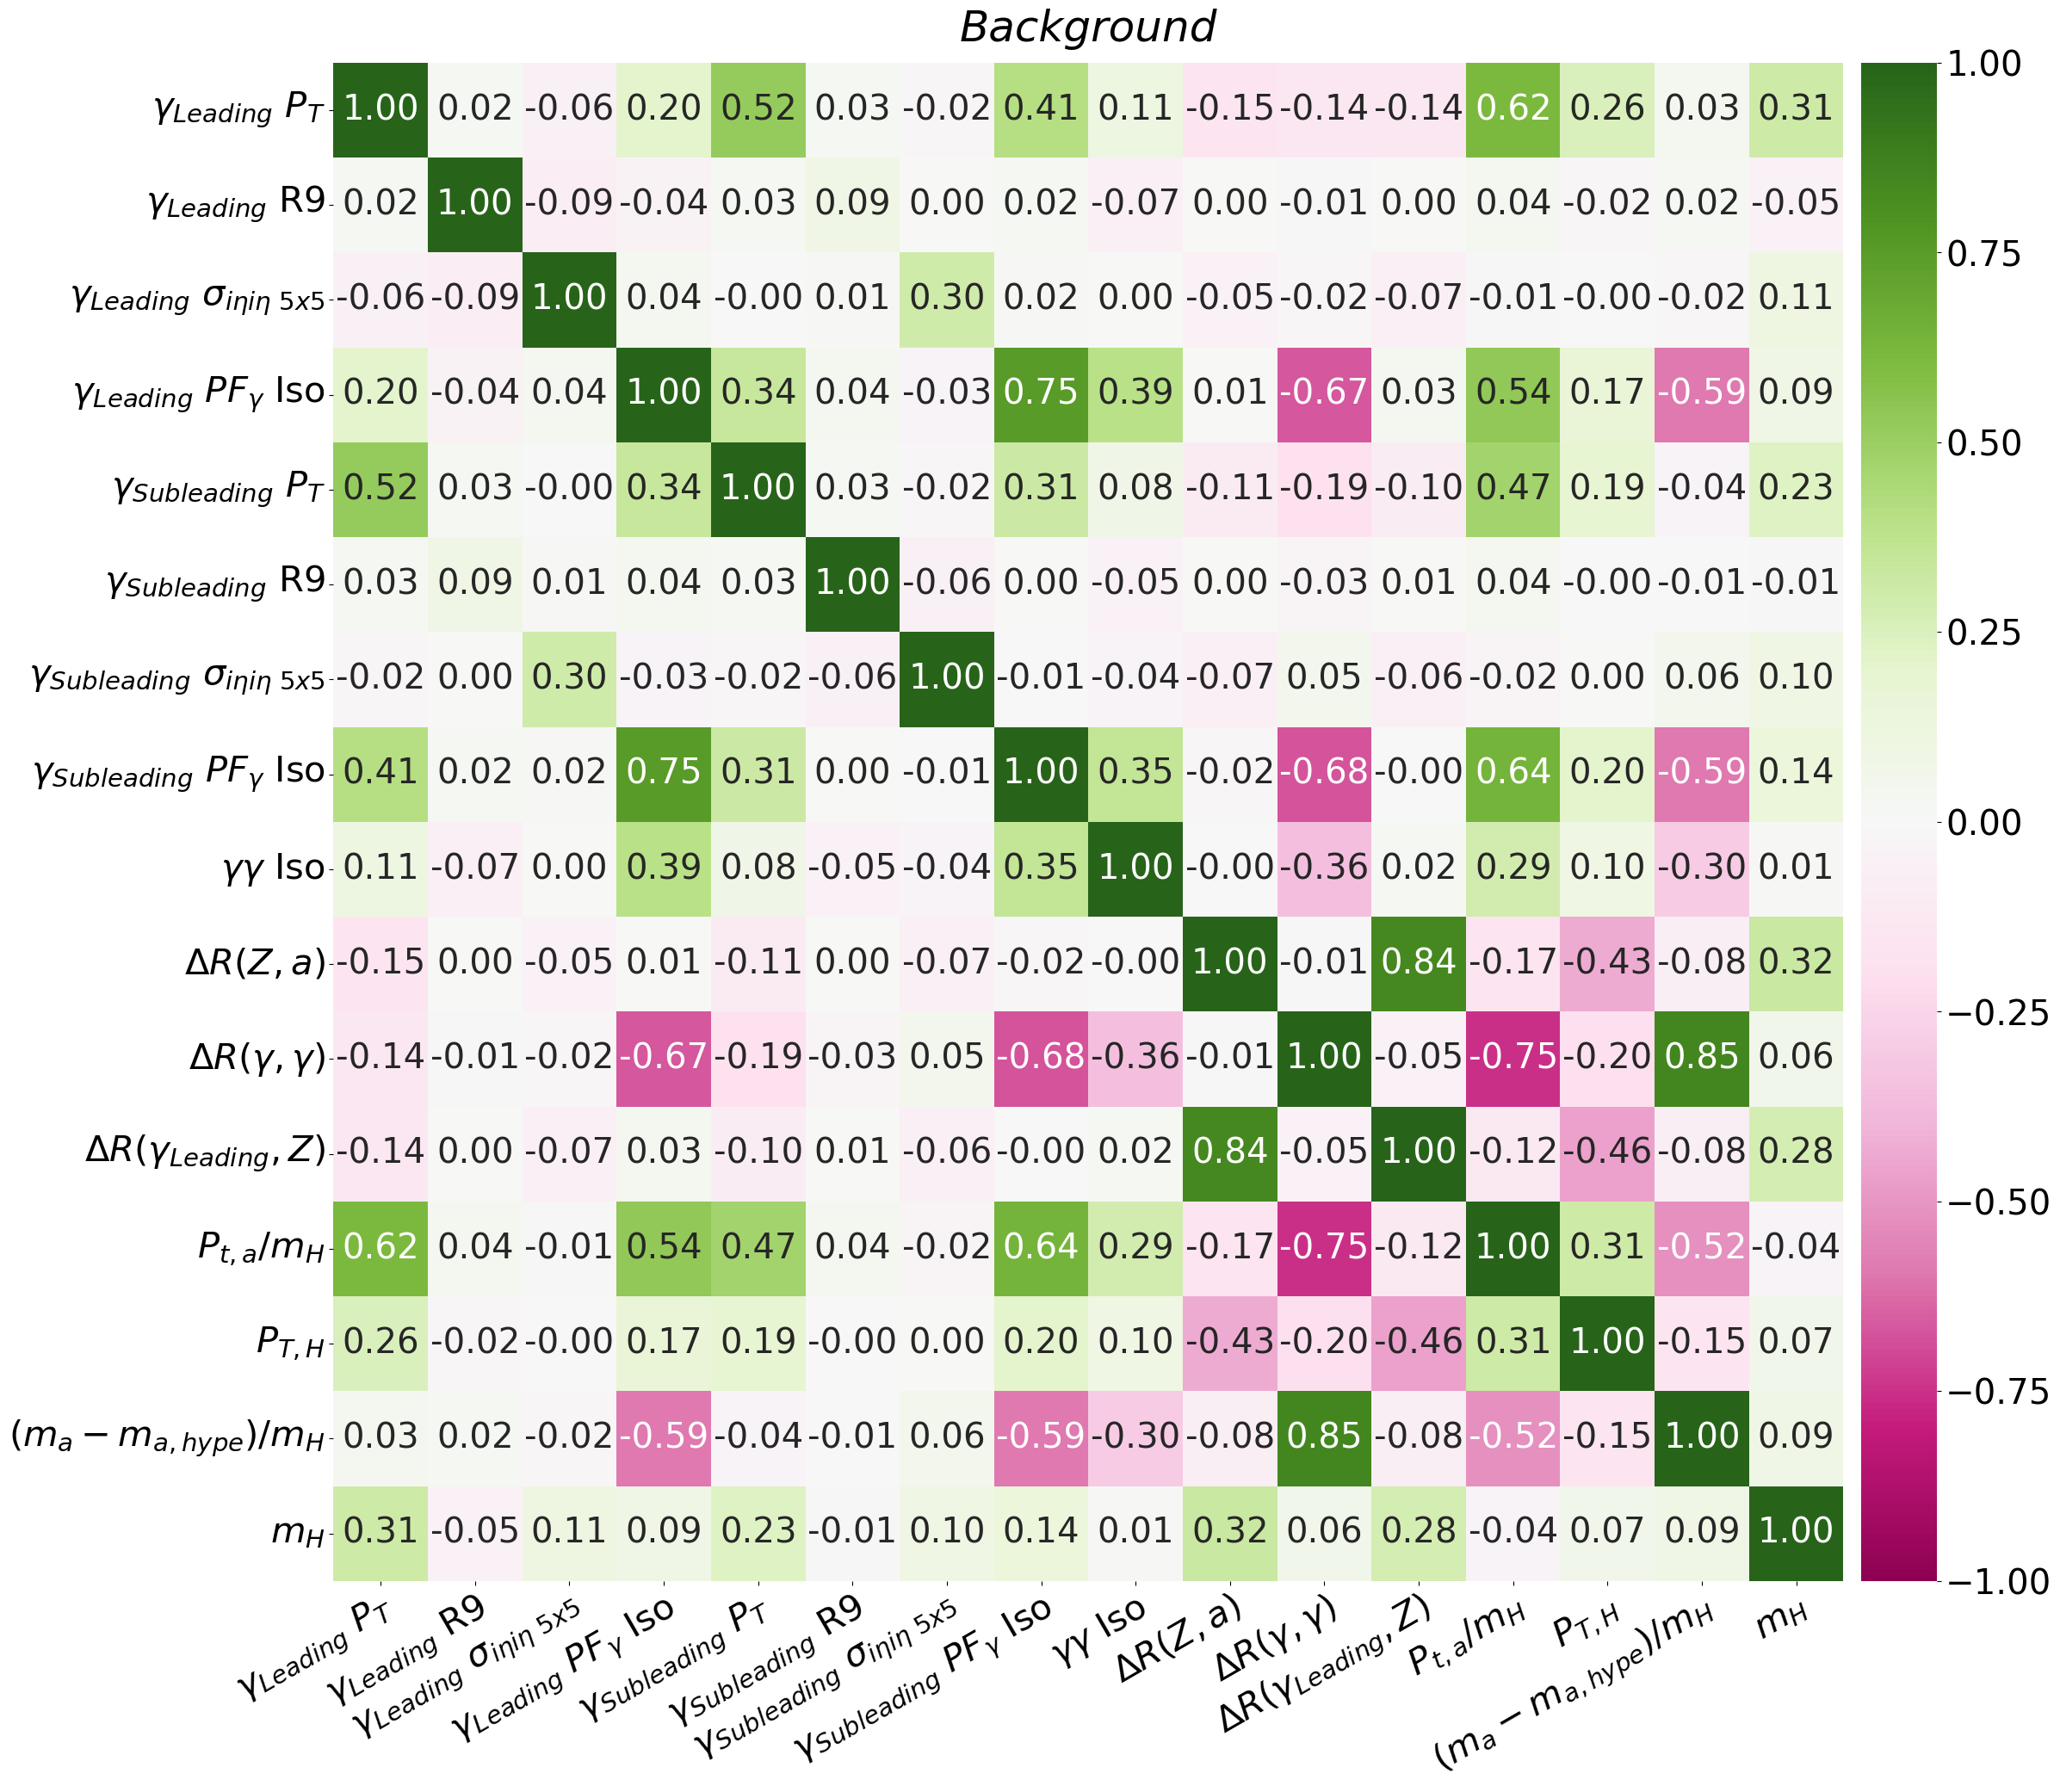

In [8]:
print(variables)

plt.figure(figsize=(24, 21))
ax1 = plt.gca()
# Signal heatmap

cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(df_bkg_all[variables+["param"]+["H_m"]].corr(), annot=True, fmt=".2f", ax = ax1, cmap="PiYG", annot_kws={"size": 29}, cbar_kws={'pad': 0.01}, vmin=-1, vmax=1)
ax1.set_title('Background', fontsize=36, fontstyle='italic', pad=18)
ax1.tick_params(axis='both', which='major', labelsize=30)

# Adjust z-axis (colorbar) label size
cbar1 = ax1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=29)

ax1.set_xticklabels(["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{H}$"])
ax1.set_yticklabels(["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{H}$"])

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right', rotation_mode="anchor")

plt.subplots_adjust(left=0.16, right=1.03, top=0.95, bottom=0.11)

plt.savefig('./train_MVA_Fig/corr_Bkg.pdf', format='pdf')

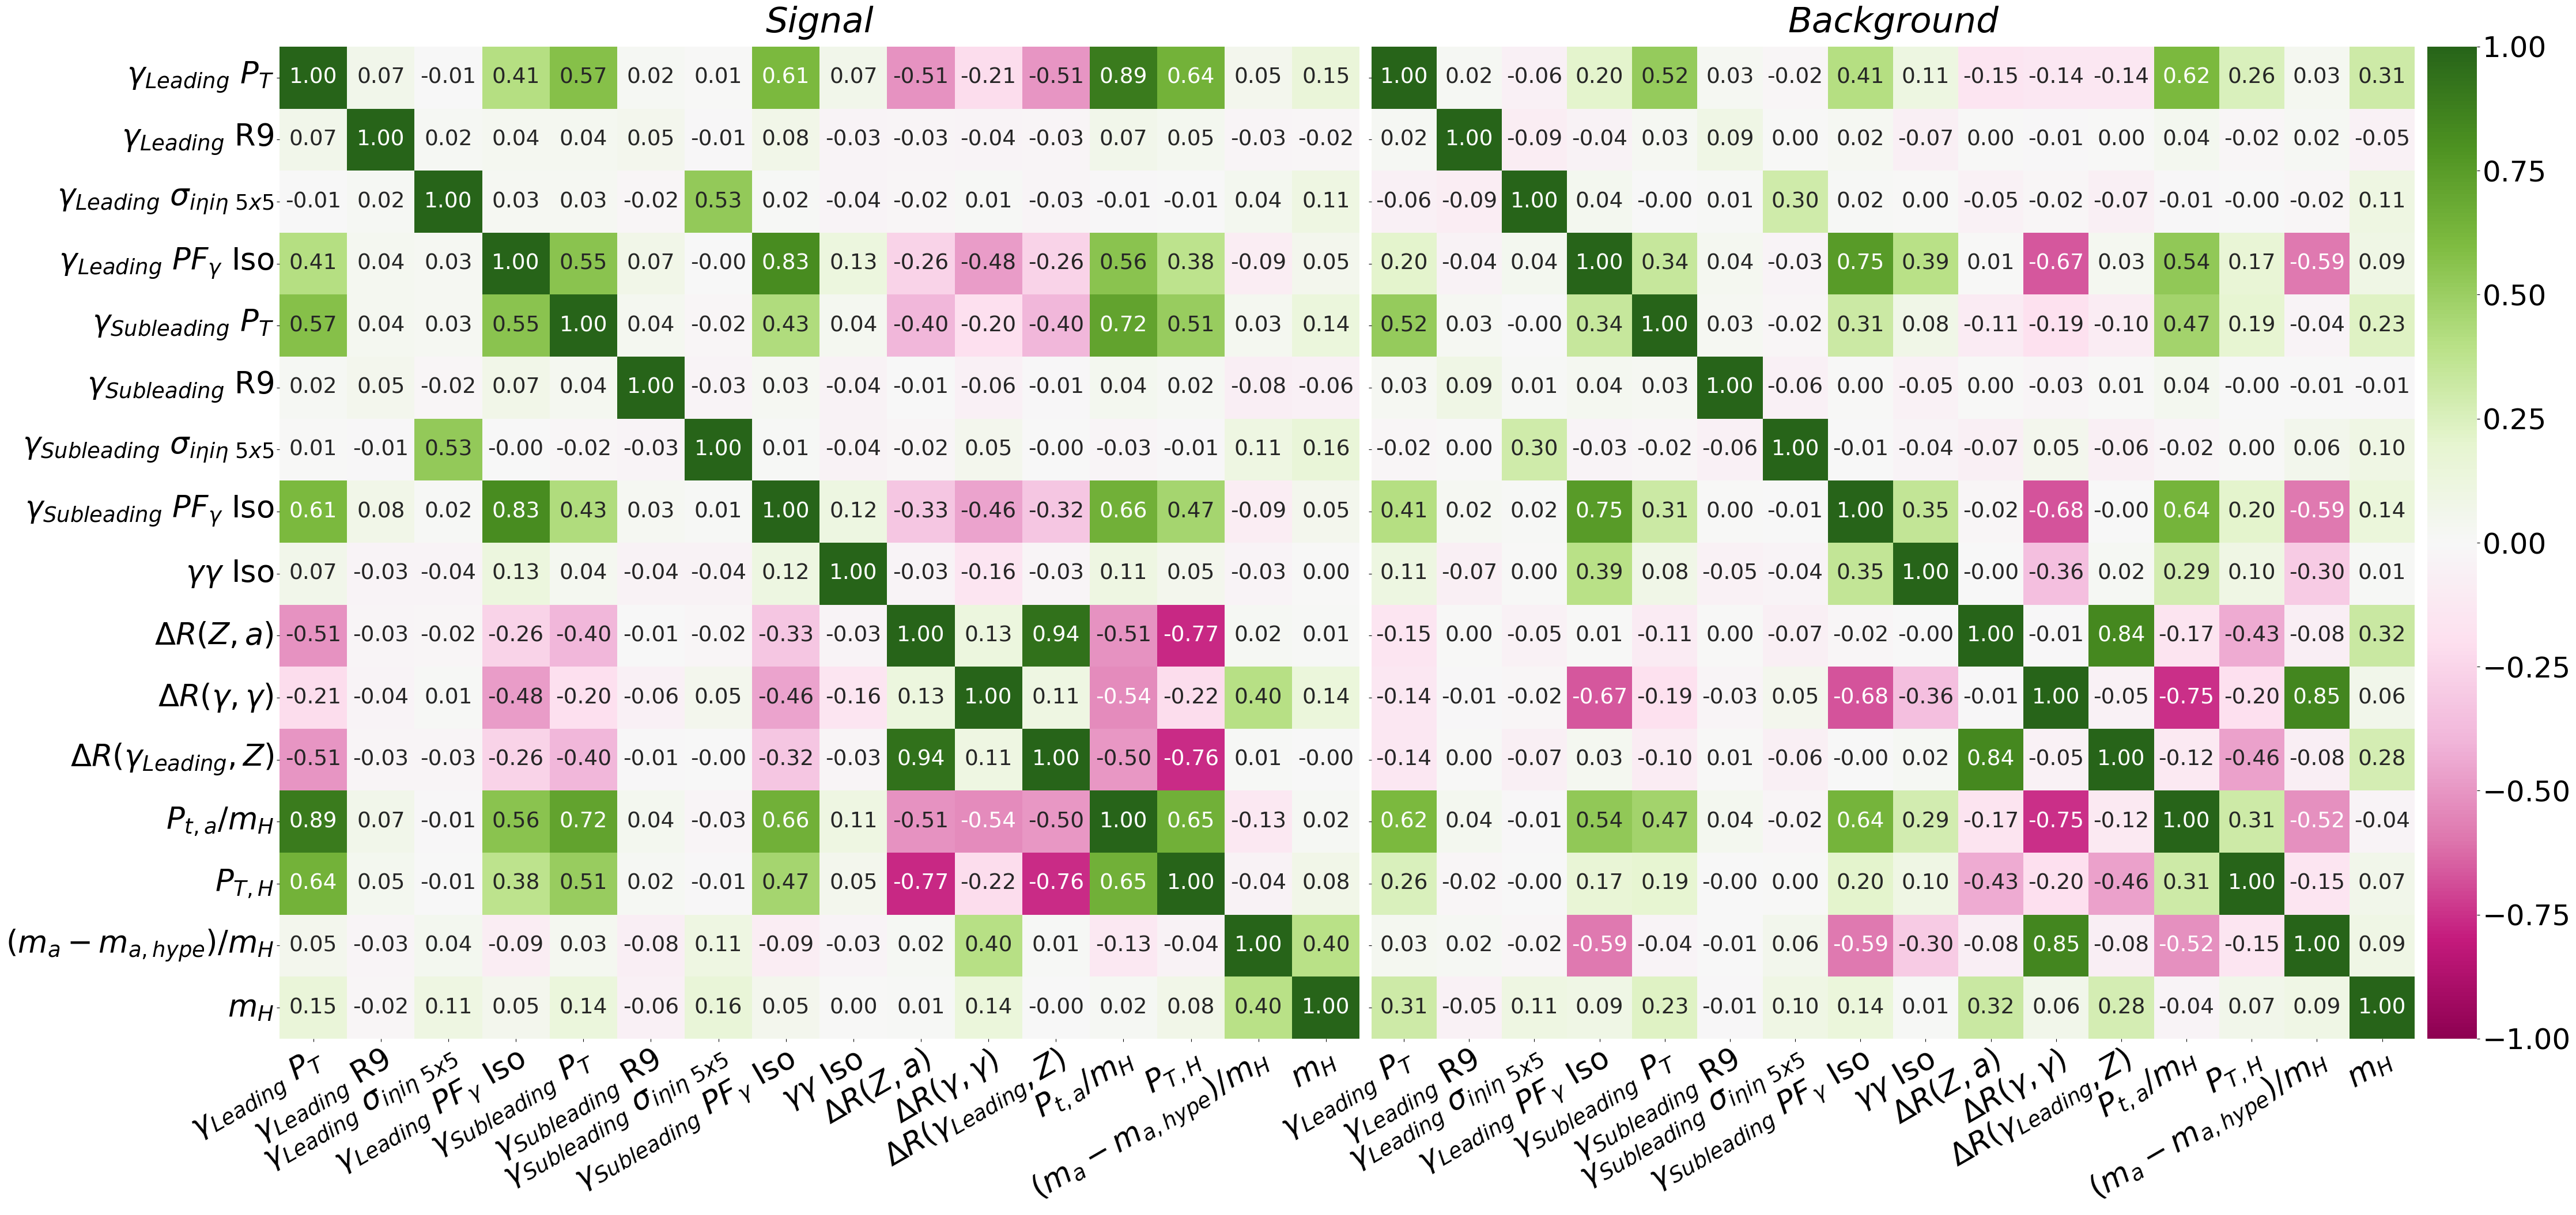

In [9]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize = (45, 21), gridspec_kw={'width_ratios': [1, 1.15]})
f.subplots_adjust(wspace = 0.01)

cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(df_sig_all[variables+["param"]+["H_m"]].corr(), annot=True, fmt=".2f", ax = ax1, cmap="PiYG", annot_kws={"size": 27}, vmin=-1, vmax=1, cbar=False)
ax1.set_title('Signal', fontsize=44, fontstyle='italic', pad=18)
ax1.tick_params(axis='both', which='major', labelsize=38)

ax1.set_xticklabels(["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{H}$"])
ax1.set_yticklabels(["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{H}$"])

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right', rotation_mode="anchor")
############################################################################################################## 
sns.heatmap(df_bkg_all[variables+["param"]+["H_m"]].corr(), annot=True, fmt=".2f", ax = ax2, cmap="PiYG", annot_kws={"size": 27}, cbar_kws={'pad': 0.01}, vmin=-1, vmax=1)
ax2.set_title('Background', fontsize=44, fontstyle='italic', pad=18)
ax2.tick_params(axis='both', which='major', labelsize=38)

# Adjust z-axis (colorbar) label size
cbar2 = ax2.collections[0].colorbar
cbar2.ax.tick_params(labelsize=36)

ax2.set_yticklabels([])
ax2.set_xticklabels(["$\gamma_{Leading} \ P_{T}$", "$\gamma_{Leading}$ R9", "$\gamma_{Leading}$ $\sigma_{i \eta i \eta \ 5x5}$", " $\gamma_{Leading}$ $PF_{\gamma}$ Iso", "$\gamma_{Subleading} \ P_{T}$", "$\gamma_{Subleading}$ R9", "$\gamma_{Subleading}$ $\sigma_{i \eta i \eta \ 5x5}$", "$\gamma_{Subleading}$ $PF_{\gamma}$ Iso", "$\gamma\gamma$ Iso", "$\Delta R(Z,a)$", "$\Delta R(\gamma,\gamma)$", "$\Delta R(\gamma_{Leading}, Z)$", "$P_{t,a} / m_{H}$", "$P_{T,H}$", "$(m_{a} - m_{a, hype}) / m_{H}$", "$m_{H}$"])

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right', rotation_mode="anchor")

f.subplots_adjust(left=0.11, right=1.01, top=0.95, bottom=0.13)

f.show()

plt.savefig('./train_MVA_Fig/corr_Sig_Bkg.pdf', format='pdf')

In [10]:
var_indices = [df_sig_all.columns.get_loc(v) for v in variables+['param']] # get positions of all the variables set above
mass_var_indices = [df_sig_all.columns.get_loc(v) for v in mass_variables]
wt_var_indices = [df_sig_all.columns.get_loc(v) for v in wt_variables]
Hm_var_indices = [df_sig_all.columns.get_loc(v) for v in ['H_m']]
# cat_var_indices = [df_sig_all.columns.get_loc(v) for v in rewt_variables]

signal = df_sig_all.values
signal_a = df_sig_a.values
# signal_VBF = df_sig_VBF.values
background = df_bkg_all.values
background_DY = df_bkg_dy.values
# background_ZG = df_bkg_ZG.values

print("Number of signal MC events:",len(signal))
print("Number of background MC events:",len(background))
print("Number of background DY MC events:",len(background_DY))
# print("Number of background ZG MC events:",len(background_ZG))
#print("Number of background TT MC events:",len(background_TT))

nsigw = np.sum(signal[:,wt_var_indices])
nbkgw = np.sum(background[:,wt_var_indices])
nbkgw_DY = np.sum(background_DY[:,wt_var_indices])
# nbkgw_ZG = np.sum(background_ZG[:,wt_var_indices])
#nbkgw_TT = np.sum(background_TT[:,wt_var_indices])

print("expected number of events for signal: ")
print(nsigw)
print("expected number of events for all bkg: ")
print(nbkgw)
print("expected number of events for DY bkg: ")
print(nbkgw_DY)
# print("expected number of events for ZG bkg: ")
# print(nbkgw_ZG)
#print("expected number of events for TT bkg: ")
#print(nbkgw_TT)

sig = len(signal)
bkg = len(background)
total = bkg + sig
print('Raw events:\n    Total: {}\n    Signal: {} ({:.2f}% of total)\n    Background: {} ({:.2f}% of total)\n'.format(total, sig, 100 * sig / total, bkg, 100 * bkg / total))
weight_for_0 = (1.0 / bkg)*(total)/2.0
weight_for_1 = (1.0 / sig)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class background: {:.2f}'.format(weight_for_0))
print('Weight for class signal: {:.2f}'.format(weight_for_1))
scale_weight = (1.0*bkg)/(sig*1.0)
print('scale weight : {:.2f}'.format(scale_weight))

Number of signal MC events: 245591
Number of background MC events: 23169
Number of background DY MC events: 23169
expected number of events for signal: 
4527.525456914849
expected number of events for all bkg: 
34549.54691844785
expected number of events for DY bkg: 
34549.54691844785
Raw events:
    Total: 268760
    Signal: 245591 (91.38% of total)
    Background: 23169 (8.62% of total)

Weight for class background: 5.80
Weight for class signal: 0.55
scale weight : 0.09


In [11]:
#signal label as 1, bkg label as 0 (ground truth)
sig_label_a = np.ones(len(signal_a))
# sig_label_VBF = np.ones(len(signal_VBF))
#sig_label_ttH = np.ones(len(signal_ttH))
#sig_label_WH = np.ones(len(signal_WH))
#sig_label_ZH = np.ones(len(signal_ZH))
bkg_label_DY = np.zeros(len(background_DY))
# bkg_label_ZG = np.zeros(len(background_ZG))
#bkg_label_TT = np.zeros(len(background_TT))

sig_proc_a = -1*np.ones(len(signal_a))
# sig_proc_VBF = -2*np.ones(len(signal_VBF))
#sig_proc_ttH = -3*np.ones(len(signal_ttH))
#sig_proc_WH = -4*np.ones(len(signal_WH))
#sig_proc_ZH = -5*np.ones(len(signal_ZH))
bkg_proc_DY = np.ones(len(background_DY))
# bkg_proc_ZG = 2*np.ones(len(background_ZG))
#bkg_proc_TT = 3*np.ones(len(background_TT))

x = np.concatenate((signal_a, background_DY))
y = np.concatenate((sig_label_a, bkg_label_DY))
z = np.concatenate((sig_proc_a, bkg_proc_DY))

In [12]:
# split data into train and test sets
seed = 123
test_size = 0.5
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=test_size, random_state=seed)

# For training we ignore the columns with the event ID information
x_train_reduced = x_train[:,var_indices]
x_train_w = x_train[:,wt_var_indices].flatten()
x_train_mass = x_train[:,Hm_var_indices].flatten()
x_test_reduced = x_test[:,var_indices]
x_test_w = x_test[:,wt_var_indices].flatten()
x_test_mass = x_test[:,Hm_var_indices].flatten()
# x_test_mass = x_test[:,mass_var_indices].flatten()
# x_test_cats = x_test[:,cat_var_indices]

print(x_test_reduced.shape)
print(x_train_reduced.shape)
print(x_train.shape)
print(len(x_train_w))
print(x[0])
print(x_train_w)
print("finish")

(134380, 15)
(134380, 15)
(134380, 19)
134380
[2.14741611e+01 9.89748716e-01 1.04567138e-02 1.03421974e+01
 1.16510029e+01 9.80397582e-01 1.22568235e-02 2.09069195e+01
 0.00000000e+00 1.71409714e+00 6.41746148e-02 1.71229875e+00
 2.65530109e-01 3.30871162e+01 1.01521206e+00 1.24742882e+02
 1.92232709e-02 1.00000000e+00 1.21947311e-04]
[0.03066979 2.98132297 0.01179521 ... 0.03608527 0.01840555 2.02977047]
finish


# Optuna for optimization

In [13]:
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    n_estimators = trial.suggest_int('n_estimators', 50, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 100)
    gamma = trial.suggest_float('gamma', 0.001, 0.5)
    reg_alpha = trial.suggest_float('reg_alpha', 0.001, 5)
    reg_lambda = trial.suggest_float('reg_lambda', 0.001, 10)
    
    model = xgb.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_weight,
        #scale_pos_weight=1,
        early_stopping_rounds=10,
        eval_metric=["logloss"],
        base_score=0.5,
        nthread=4,
        #n_jobs=2,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bynode=1, 
        colsample_bytree=1, 
        gamma=gamma,
        max_delta_step=0,
        objective='binary:logistic', 
        random_state=1, 
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        subsample=1, 
        verbosity=1)
    eval_set = [(x_train_reduced, y_train), (x_test_reduced, y_test)]
    model.fit(x_train_reduced, y_train, sample_weight=xgb.DMatrix(x_train).get_weight() , eval_set=eval_set, verbose=False)
    #preds = model.predict(x_test_reduced)
    #rmse = accuracy_score(y_test, preds)
    preds_test = model.predict_proba(x_test_reduced)[:, 1]
    preds_train = model.predict_proba(x_train_reduced)[:, 1]
    fpr_test, tpr_test, boundary_test = roc_curve(y_test, preds_test)
    fpr_train, tpr_train, boundary_train = roc_curve(y_train, preds_train)
    auc_test = auc(fpr_test,tpr_test)
    auc_train = auc(fpr_train,tpr_train)
    overfit = abs(auc_test-auc_train)
    return auc_test, overfit

# Optimize hyperparameters for XGBoost
study_name = "Za-study"
storage_name = "sqlite:///{}.db".format(study_name)
xgb_study = optuna.create_study(directions=['maximize', 'minimize'], study_name=study_name, storage=storage_name, load_if_exists=True)
xgb_study.optimize(objective, n_trials=20, timeout=300)
# xgb_study.optimize(objective, n_trials=5, timeout=300)

[I 2024-11-21 06:59:36,188] A new study created in RDB with name: Za-study
[I 2024-11-21 06:59:40,803] Trial 0 finished with values: [0.9835422752694992, 0.0011813637281709033] and parameters: {'learning_rate': 0.019070278259070907, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 71, 'gamma': 0.1988428492530215, 'reg_alpha': 1.2454000688800697, 'reg_lambda': 6.141966291468338}.
[I 2024-11-21 06:59:47,217] Trial 1 finished with values: [0.9890946423956293, 0.0018780869066279404] and parameters: {'learning_rate': 0.10907855363066615, 'n_estimators': 150, 'max_depth': 5, 'min_child_weight': 54, 'gamma': 0.34880191510844605, 'reg_alpha': 3.6764196137140415, 'reg_lambda': 3.6031781556621607}.
[I 2024-11-21 06:59:51,695] Trial 2 finished with values: [0.9889537844814115, 0.0014951695240709162] and parameters: {'learning_rate': 0.2965588490545789, 'n_estimators': 250, 'max_depth': 3, 'min_child_weight': 43, 'gamma': 0.4170327173338276, 'reg_alpha': 2.5618943993474015, 'reg_lambda': 7

In [14]:
optuna.visualization.plot_pareto_front(xgb_study, target_names=['auc_test', 'overfit']).show()
optuna.visualization.plot_param_importances(xgb_study, target=lambda t: t.values[0], target_name="auc_test").show()
optuna.visualization.plot_param_importances(xgb_study, target=lambda t: t.values[1], target_name="overfit").show()


print("总试验次数：", len(xgb_study.trials))

print("帕累托最优解集(Pareto front):")
trials = sorted(xgb_study.best_trials, key=lambda t: t.values) # 对字典best_trials按values从小到达排序
for trial in trials:
    print("     Trial:", trial.number)
    print(f"    Values: auc_test={trial.values[0]}, overfit={ trial.values[1]}")
    print("    Params: ", trial.params, '\n')


#optuna.visualization.plot_optimization_history(xgb_study).show()
#optuna.visualization.plot_param_importances(xgb_study).show()
#optuna.visualization.plot_slice(xgb_study).show()
#optuna.visualization.plot_parallel_coordinate(xgb_study).show()
# Get the best hyperparameters for each model
#best_xgb_params = xgb_study.best_params
#print(best_xgb_params)

总试验次数： 20
帕累托最优解集(Pareto front):
     Trial: 10
    Values: auc_test=0.986884184069232, overfit=0.0011020935689272093
    Params:  {'learning_rate': 0.13114102267711406, 'n_estimators': 50, 'max_depth': 3, 'min_child_weight': 54, 'gamma': 0.04045659612329388, 'reg_alpha': 4.6194764385838205, 'reg_lambda': 0.15950067379461075} 

     Trial: 17
    Values: auc_test=0.9878898677186075, overfit=0.0011511599635257719
    Params:  {'learning_rate': 0.08033007690486088, 'n_estimators': 150, 'max_depth': 3, 'min_child_weight': 94, 'gamma': 0.3337806534770434, 'reg_alpha': 4.349919465107057, 'reg_lambda': 5.807158770688869} 

     Trial: 4
    Values: auc_test=0.988138453005841, overfit=0.0012668009073606434
    Params:  {'learning_rate': 0.0603879136183775, 'n_estimators': 250, 'max_depth': 3, 'min_child_weight': 97, 'gamma': 0.47572739370400563, 'reg_alpha': 0.6254181352972578, 'reg_lambda': 4.488708509291322} 

     Trial: 2
    Values: auc_test=0.9889537844814115, overfit=0.0014951695240709

In [15]:
model_file = './model_Za_BDT_{}.pkl'.format(tree_name)

#XGBClassifier/BDT model parameters
#https://xgboost.readthedocs.io/en/latest/python/python_api.html

#depth_best=3
#learning_rate_best=0.1
#n_estimators_best=500
#min_child_weight_best=5

#depth_best=3
#learning_rate_best=0.1
#n_estimators_best=100
#min_child_weight_best=5

best_xgb_params = trials[0].params

# fit model no training sample
model_best = xgb.XGBClassifier(
    max_depth=best_xgb_params['max_depth'],
    learning_rate=best_xgb_params['learning_rate'],
    n_estimators=best_xgb_params['n_estimators'],
    min_child_weight=best_xgb_params['min_child_weight'],
    scale_pos_weight=scale_weight,
    #scale_pos_weight=1,
    early_stopping_rounds=10,
    eval_metric=["logloss"],
    base_score=0.5,
    nthread=4,
    #n_jobs=2,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bynode=1, 
    colsample_bytree=1, 
    gamma=best_xgb_params['gamma'],
    max_delta_step=0,
    objective='binary:logistic', 
    random_state=0, 
    reg_alpha=best_xgb_params['reg_alpha'],
    reg_lambda=best_xgb_params['reg_lambda'],
    subsample=1, 
    verbosity=1)
print(model_best)

# do cross validation
#xgtrain = xgb.DMatrix(x_train_reduced, label=y_train)

#xgb_param = model_best.get_xgb_params()
#cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['auc'],early_stopping_rounds=50, stratified=True, seed=1301)
#print('Best number of trees = {}'.format(cvresult.shape[0]))
#print(cvresult)

#model_best.set_params(n_estimators=cvresult.shape[0])


#early_stopping_rounds (int): Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training.
eval_set = [(x_train_reduced, y_train), (x_test_reduced, y_test)]
model_best.fit(x_train_reduced, y_train, sample_weight=xgb.DMatrix(x_train).get_weight() , eval_set=eval_set, verbose=False)
#model_best.fit(x_train_reduced, y_train , eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['logloss'], feature_types=None,
              gamma=0.04045659612329388, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13114102267711406,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0, max_depth=3, max_leaves=None,
              min_child_weight=54, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['logloss'], feature_types=None,
              gamma=0.04045659612329388, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13114102267711406,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0, max_depth=3, max_leaves=None,
              min_child_weight=54, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [16]:
print("save model file ",model_file)
output = open(model_file, 'wb')
pickle.dump(model_best, output)
output.close()

save model file  ./model_Za_BDT_passedEvents.pkl


In [17]:
# Read in model saved from previous running of BDT
model_file = './model_Za_BDT_{}.pkl'.format(tree_name)
filename=model_file
# load the model from disk
model = pickle.load(open(filename, 'rb'))

134380
134380
134380
134380
134380
0.4008379396325028
0.32221682287031883
KstestResult(statistic=0.00360590188590712, pvalue=0.4008379396325028, statistic_location=86.56778, statistic_sign=1)
Anderson_ksampResult(statistic=0.028668541784921037, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.25)


/tmp/pelai/ipykernel_497613/1922804259.py:35: UserWarning:

p-value capped: true value larger than 0.25



MannwhitneyuResult(statistic=7520059517.0, pvalue=0.27172674025482413)
122786
11594
Ttest_indResult(statistic=-1.3570877292688068, pvalue=0.174754584114798)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['logloss'], feature_types=None,
              gamma=0.04045659612329388, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13114102267711406,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0, max_depth=3, max_leaves=None,
              min_child_weight=54, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)
(134380, 15)
(134380, 15)


/afs/cern.ch/user/p/pelai/.conda/envs/python_Three/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in true_divide



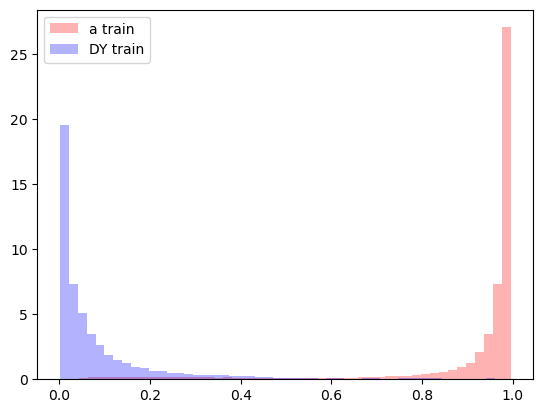

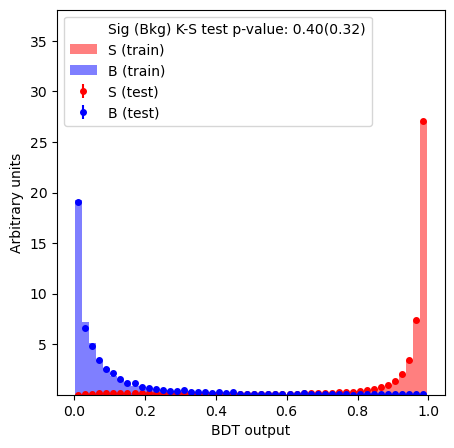

In [18]:


#make predictions for test sample
y_test_pred = model.predict_proba(x_test_reduced)[:, 1]
y_train_pred = model.predict_proba(x_train_reduced)[:, 1]

print(len(z_test))
print(len(y_test_pred))
print(len(y_test))
print(len(x_test_w))
print(len(x_test_mass))
##########################################################
# make histogram of discriminator value for signal and bkg
##########################################################

y_test_frame = pd.DataFrame({'truth':z_test, 'disc':y_test_pred, 'label':y_test, 'weight':x_test_w, 'H_mass':x_test_mass})
y_train_frame = pd.DataFrame({'truth':z_train, 'disc':y_train_pred, 'label':y_train, 'weight':x_train_w, 'H_mass':x_train_mass})

disc_train_bkg_DY = y_train_frame[y_train_frame['truth'] == 1]['disc'].values
disc_train_signal_a = y_train_frame[y_train_frame['truth'] == -1]['disc'].values
disc_train_bkg_all = y_train_frame[y_train_frame['truth'] > 0]['disc'].values
disc_train_signal_all = y_train_frame[y_train_frame['truth'] < 0]['disc'].values

disc_test_bkg_DY = y_test_frame[y_test_frame['truth'] == 1]['disc'].values
disc_test_signal_a = y_test_frame[y_test_frame['truth'] == -1]['disc'].values
disc_test_bkg_all = y_test_frame[y_test_frame['truth'] > 0]['disc'].values
disc_test_signal_all = y_test_frame[y_test_frame['truth'] < 0]['disc'].values


# K-S test
stat_signal,pval_signal = ks_2samp(disc_train_signal_all,disc_test_signal_all)
#stat_signal,pval_signal = ks_2samp(disc_train_signal_all[disc_train_signal_all>0.5],disc_test_signal_all[disc_test_signal_all>0.5])
stat_bkg,pval_bkg = ks_2samp(disc_train_bkg_all,disc_test_bkg_all)
print(pval_signal)
print(pval_bkg)
print(ks_2samp(disc_train_signal_all*100.0,disc_test_signal_all*100.0))
print(stats.anderson_ksamp([disc_train_signal_all,disc_test_signal_all]))
print(stats.mannwhitneyu(disc_train_signal_all,disc_test_signal_all,alternative='two-sided',use_continuity = False))
print(len(disc_train_signal_all))
print(len(disc_train_bkg_all))
print(stats.ttest_ind(disc_train_signal_all,disc_test_signal_all))

bins = 50

plt.figure()
#plt.hist(disc_train_bkg_all, density=True, bins=bins, alpha=0.3, label='bkg train', color='red',weights=y_train_frame[y_train_frame['truth'] > 0]['weight'])
#plt.hist(disc_train_signal_all, density=True, bins=bins, alpha=0.3, label='signal train', color='blue',weights=y_train_frame[y_train_frame['truth'] < 0]['weight'])
plt.hist(disc_train_signal_a, density=True, bins=bins, alpha=0.3, label='a train', color='red',weights=y_train_frame[y_train_frame['truth'] == -1]['weight'])
# plt.hist(disc_train_signal_VBF, density=True, bins=bins, alpha=0.3, label='VBF train', color='green',weights=y_train_frame[y_train_frame['truth'] == -2]['weight'])
plt.hist(disc_train_bkg_DY, density=True, bins=bins, alpha=0.3, label='DY train', color='blue',weights=y_train_frame[y_train_frame['truth'] == 1]['weight'])
# plt.hist(disc_train_bkg_ZG, density=True, bins=bins, alpha=0.3, label='ZG train', color='black',weights=y_train_frame[y_train_frame['truth'] == 2]['weight'])
#plt.hist(disc_train_bkg_TT, density=True, bins=bins, alpha=0.3, label='TT train', color='yellow',weights=y_train_frame[y_train_frame['truth'] == 3]['weight'])


#plt.scatter(x_values, y_values, s=100) 

#plt.hist(disc_test_bkg_all, normed=True, bins=50, alpha=0.3, label='DY bkg test', color='red')
#plt.hist(disc_test_signal, normed=True, bins=50, alpha=0.3, label='signal test', color='blue')
plt.legend(loc='best')

compare_train_test(model,x_train_reduced,y_train,z_train,x_train_w,x_test_reduced,y_test,z_test,x_test_w,bins=bins)

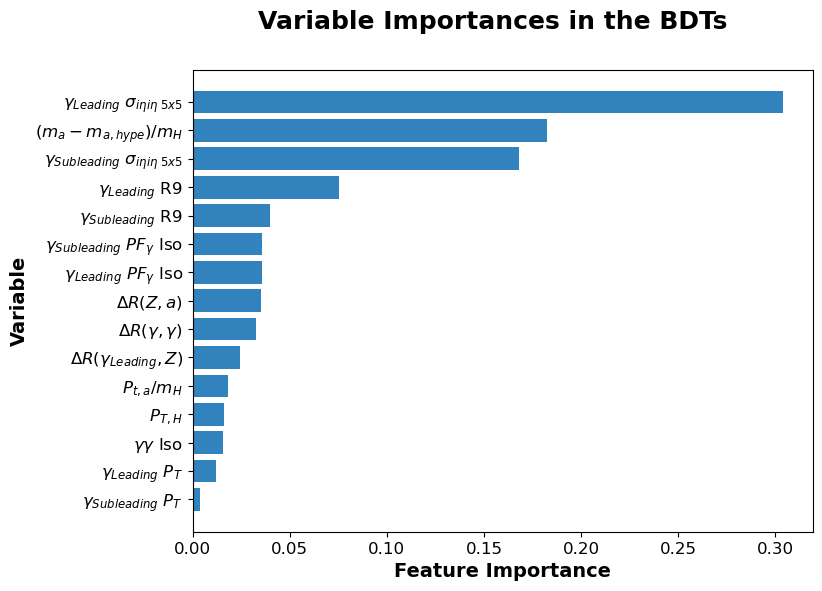

In [19]:
##########################################################
# Rank training variable of importance
##########################################################
# sort variables by feature importance
sorted_idx = model.feature_importances_.argsort()
#variables = variables + ['param']
#variables_label = variables_label
variables_sorted = [xlabel[i] for i in sorted_idx]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(variables_sorted, model.feature_importances_[sorted_idx], color='#3182bd')

# Add axis labels and increase font size
ax.set_xlabel('Feature Importance', fontsize=14, fontweight='bold')
ax.set_ylabel('Variable', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add title and caption
fig.suptitle('Variable Importances in the BDTs', fontsize=18, fontweight='bold')
#fig.text(0.5, 0.05, 'Source: Your data analysis', ha='center', fontsize=10, color='gray')

# Save and show the plot
#plt.savefig('./plot/rank.png', dpi=300, bbox_inches='tight')
plt.show()

[0.         0.         0.         ... 0.99904968 0.99974082 1.        ] [0.         0.00196246 0.00200318 ... 1.         1.         1.        ]
test K-S value:  0.8958770418923466
train K-S value:  0.8985183619535031


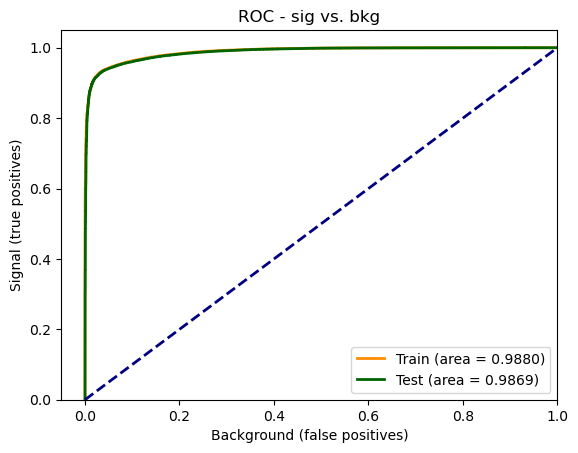

In [20]:
##########################################################
# make ROC curve
##########################################################

#get roc curve
#fpr, tpr, _ = roc_curve(y_test, y_pred, x_test_w)

fpr_test, tpr_test, boundary_test = roc_curve(y_test_frame['label'].values, y_test_frame['disc'].values)
fpr_train, tpr_train, boundary_train = roc_curve(y_train_frame['label'].values, y_train_frame['disc'].values)
print(fpr_test, tpr_test)
ks_test = max(tpr_test-fpr_test)
auc_test = auc(fpr_test,tpr_test)
print("test K-S value: ",ks_test)

ks_train = max(tpr_train-fpr_train)
auc_train = auc(fpr_train,tpr_train)
print("train K-S value: ",ks_train)

#plot roc curve
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label=r'Train (area = {0:.4f})'.format(auc_train))

plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label=r'Test (area = {0:.4f})'.format(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background (false positives)')
plt.ylabel('Signal (true positives)')
plt.title(r'ROC - sig vs. bkg')
plt.legend(loc="lower right")
#plt.savefig('./plot/ROC.png')

# Start BDT Optimization for DY

In [21]:
from ROOT import *
from array import array

In [22]:

dfs = {}
tree = {}
for year in years:
    dfs[year] = {}
    tree[year] = {}
    for dataset in bkg_name + data_name:
        dfs[year][dataset], tree[year][dataset] = convert_ntuple_dataframe("{}/{}/".format(file_path,dataset),"{}_{}.root".format(tree_name, year), tree_name, variables+mass_variables+wt_variables, selections="H_m>110 && H_m<180")
        dfs[year][dataset]['mass'] = list(random.choice(mass_list) for _ in range(dfs[year][dataset].shape[0]))
        dfs[year][dataset]['param'] = (dfs[year][dataset]['ALP_m'] - dfs[year][dataset]['mass']) / dfs[year][dataset]['H_m']

    for dataset in sig_name:
        dfs[year][dataset] = {}
        tree[year][dataset] = {}
        for mass in mass_list:
            dfs[year][dataset][mass], tree[year][dataset][mass] = convert_ntuple_dataframe("{}/{}/".format(file_path, dataset), 'ALP_M'+str(int(mass))+'.root', tree_name, variables+mass_variables+wt_variables, selections="H_m>110 && H_m<180")
            dfs[year][dataset][mass]["mass"] = mass
            dfs[year][dataset][mass]['param'] = (dfs[year][dataset][mass]['ALP_m'] - dfs[year][dataset][mass]['mass']) / dfs[year][dataset][mass]['H_m']
            # dfs[year][dataset]['factor'] = dfs[year][dataset]['factor'] * dfs[year][dataset]['pho1SFs'] * dfs[year][dataset]['pho2SFs'] 



df_bkg_dy   = pd.concat([dfs[y]["DYJets"] for y in years])
df_bkg_all  = pd.concat([dfs[y][bkg] for y in years for bkg in bkg_name ])

df_sig_a    = pd.concat([dfs[y]["sig"][m] for y in years for m in mass_list])
df_sig_all  = pd.concat([dfs[y][sig][m] for y in years for sig in sig_name for m in mass_list])

df_data_all = pd.concat([dfs[y][dataset] for y in years for dataset in data_name])


signal_a = df_sig_a.values
signal = df_sig_all.values

background_DY = df_bkg_dy.values
background = df_bkg_all.values

#signal label as 1, bkg label as 0 (ground truth)
sig_label_a = np.ones(len(signal_a))
bkg_label_DY = np.zeros(len(background_DY))

sig_proc_a = -1*np.ones(len(signal_a))
bkg_proc_DY = np.ones(len(background_DY))

x = np.concatenate((signal_a, background_DY))
y = np.concatenate((sig_label_a, bkg_label_DY))
z = np.concatenate((sig_proc_a, bkg_proc_DY))

var_indices = [df_sig_all.columns.get_loc(v) for v in variables+["param"]] # get positions of all the variables set above
mass_var_indices = [df_sig_all.columns.get_loc(v) for v in mass_variables]
wt_var_indices = [df_sig_all.columns.get_loc(v) for v in wt_variables]
Hm_var_indices = [df_sig_all.columns.get_loc(v) for v in ['H_m']]
# wt_var_indices = [df_bkg_all.columns.get_loc(v) for v in wt_variables]


print("Number of signal MC events:",len(signal))
print("Number of background MC events:",len(background))
print("Number of background DY MC events:",len(background_DY))
# print("Number of background ZG MC events:",len(background_ZG))

nsigw = np.sum(signal[:,wt_var_indices])
nbkgw = np.sum(background[:,wt_var_indices])
nbkgw_DY = np.sum(background_DY[:,wt_var_indices])
# nbkgw_ZG = np.sum(background_ZG[:,wt_var_indices])

print("expected number of events for signal: ")
print(nsigw)
print("expected number of events for all bkg: ")
print(nbkgw)
print("expected number of events for DY bkg: ")
print(nbkgw_DY)
# print("expected number of events for ZG bkg: ")
# print(nbkgw_ZG)

sig = len(signal)
bkg = len(background)
total = bkg + sig
print('Raw events:\n    Total: {}\n    Signal: {} ({:.2f}% of total)\n    Background: {} ({:.2f}% of total)\n'.format(total, sig, 100 * sig / total, bkg, 100 * bkg / total))
weight_for_0 = (1.0 / bkg)*(total)/2.0
weight_for_1 = (1.0 / sig)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class background: {:.2f}'.format(weight_for_0))
print('Weight for class signal: {:.2f}'.format(weight_for_1))
scale_weight = (1.0*bkg)/(sig*1.0)
print('scale weight : {:.2f}'.format(scale_weight))

Number of signal MC events: 245591
Number of background MC events: 23169
Number of background DY MC events: 23169
expected number of events for signal: 
4527.525456914849
expected number of events for all bkg: 
34549.54691844785
expected number of events for DY bkg: 
34549.54691844785
Raw events:
    Total: 268760
    Signal: 245591 (91.38% of total)
    Background: 23169 (8.62% of total)

Weight for class background: 5.80
Weight for class signal: 0.55
scale weight : 0.09


Error in <THashList::Delete>: A list is accessing an object (0x15d5db90) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x15b5da50) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x15d4fee0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x15d40330) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x148a7620) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x15b9a050) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x1603bd30) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0xda89cb0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0xc670470) already deleted (list nam

In [23]:
data_all_reduced = df_data_all.to_numpy()[:,var_indices]
data_all_w = df_data_all.to_numpy()[:,wt_var_indices].flatten()
data_all_mass = df_data_all.to_numpy()[:,Hm_var_indices].flatten()
data_all_pred = model.predict_proba(data_all_reduced)[:, 1]


data_all_frame = pd.DataFrame({'truth':None, 'disc':data_all_pred, 'label':None, 'weight':data_all_w, 'H_mass':data_all_mass})

# pd.options.display.min_rows = 30
# print(data_all_frame["H_mass"])

data_SB = data_all_frame[( (data_all_frame["H_mass"] > 110) & (data_all_frame["H_mass"] < 115) ) | ( (data_all_frame["H_mass"] > 135) & (data_all_frame["H_mass"] < 180) )]
data_SR = data_all_frame[( (data_all_frame["H_mass"] > 115) & (data_all_frame["H_mass"] < 135) )]

# print(data_SB) #empty
# print(data_SR)

x_reduced = x[:,var_indices]
x_w = x[:,wt_var_indices].flatten()
x_mass = x[:,Hm_var_indices].flatten()
x_pred = model.predict_proba(x_reduced)[:, 1]

bkg_all_frame = pd.DataFrame({'truth':z, 'disc':x_pred, 'label':y, 'weight':x_w, 'H_mass':x_mass})

bkg_SB = bkg_all_frame[ (( (bkg_all_frame["H_mass"] > 110) & (bkg_all_frame["H_mass"] < 115) ) | ( (bkg_all_frame["H_mass"] > 135) & (bkg_all_frame["H_mass"] < 180) )) & (bkg_all_frame['truth'] > 0)]
bkg_SR = bkg_all_frame[(( (bkg_all_frame["H_mass"] > 115) & (bkg_all_frame["H_mass"] < 135) )) & (bkg_all_frame['truth'] > 0)]

sig_SB = bkg_all_frame[ (( (bkg_all_frame["H_mass"] > 110) & (bkg_all_frame["H_mass"] < 115) ) | ( (bkg_all_frame["H_mass"] > 135) & (bkg_all_frame["H_mass"] < 180) )) & (bkg_all_frame['truth'] < 0)]
sig_SR = bkg_all_frame[(( (bkg_all_frame["H_mass"] > 115) & (bkg_all_frame["H_mass"] < 135) )) & (bkg_all_frame['truth'] < 0)]


# print(bkg_SB) #empty
# print(bkg_SR)
# print(sig_SB) #empty
# print(sig_SR)


In [24]:
def draw_dataMC(var_name, nbins = 50,range_hl=(0,1)):
    #var_name = 'disc'
    hist_DY, bins = np.histogram(bkg_all_frame[var_name][bkg_all_frame['truth']==1], weights=bkg_all_frame['weight'][bkg_all_frame['truth']==1], bins=nbins,range=range_hl)
    # hist_ZG, _ = np.histogram(bkg_all_frame[var_name][bkg_all_frame['truth']==2], weights=bkg_all_frame['weight'][bkg_all_frame['truth']==2], bins=nbins,range=range_hl)
    #data_mass_blind = data_all_frame['H_mass'].loc[(data_all_frame['H_mass'] >= 120), 'H_mass'] = 0
    hist_data, _ = np.histogram(data_all_frame[var_name], bins=nbins,range=range_hl)
    hist_data_err = np.sqrt(hist_data)
    center = (bins[:-1] + bins[1:]) / 2

    # 绘制堆叠的直方图
    plt.bar(bins[:-1], hist_DY, width=np.diff(bins), label='DY')
    # plt.bar(bins[:-1], hist_ZG, width=np.diff(bins), label='ZG', bottom=hist_DY)
    plt.hist(bkg_all_frame[var_name][bkg_all_frame['truth']<0], weights=bkg_all_frame['weight'][bkg_all_frame['truth']<0]*10, bins=bins, histtype='step', color='r', label='Signal * 10')
    plt.errorbar(bins[:-1], hist_data, yerr=hist_data_err, fmt='.', c='black', label='data', markersize=8,capthick=0)

    plt.legend()
    plt.xlabel(var_name)
    plt.ylabel('Weighted Frequency')
    plt.title('Stacked Weighted Histogram of Mass by Truth')
    plt.subplots_adjust(left=0.15, right=0.96, top=0.94, bottom=0.1)
    plt.savefig(f'./train_MVA_Fig/weight_check_{var_name}_full_run2.pdf', format='pdf')
    plt.show()

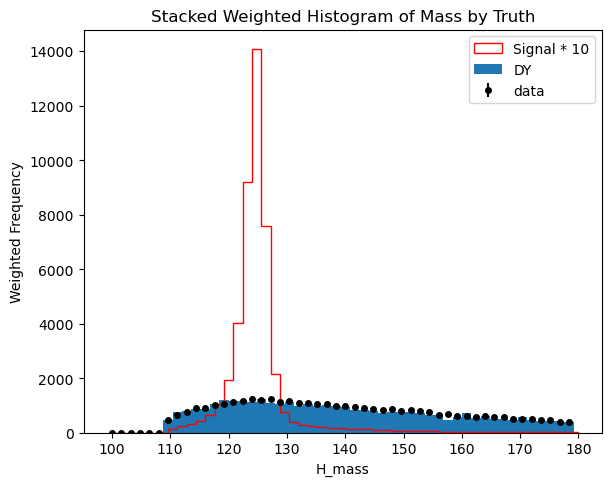

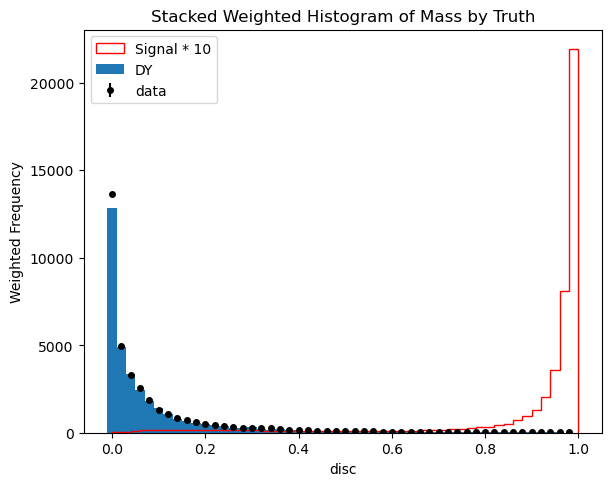

In [25]:
draw_dataMC(var_name='H_mass',nbins = 50, range_hl=(100,180))
draw_dataMC(var_name='disc',nbins = 50,range_hl=(0,1))

In [26]:
nbins = 200
hist_bkg_SB, bins = np.histogram(bkg_SB['disc'], weights=bkg_SB['weight'], bins=nbins,range=(0,1))
hist_bkg_SR, bins = np.histogram(bkg_SR['disc'], weights=bkg_SR['weight'], bins=nbins,range=(0,1))
hist_sig_SR, bins = np.histogram(sig_SR['disc'], weights=sig_SR['weight'], bins=nbins,range=(0,1))
hist_data_SB, bins = np.histogram(data_SB['disc'], weights=data_SB['weight'], bins=nbins,range=(0,1))

In [27]:
def SetgStyle():

    gStyle.SetFrameFillColor(0)
    gStyle.SetStatColor(0)
    gStyle.SetOptStat(0)
    gStyle.SetTitleFillColor(0)
    gStyle.SetCanvasBorderMode(0)
    gStyle.SetPadBorderMode(0)
    gStyle.SetFrameBorderMode(0)
    gStyle.SetPadColor(kWhite)
    gStyle.SetCanvasColor(kWhite)
    
    
    gStyle.SetCanvasDefH(600) #Height of canvas
    gStyle.SetCanvasDefW(600) #Width of canvas
    gStyle.SetCanvasDefX(0)   #POsition on screen
    gStyle.SetCanvasDefY(0)

    
    gStyle.SetPadLeftMargin(0.18)
    gStyle.SetPadRightMargin(0.05)
    gStyle.SetPadTopMargin(0.085)
    gStyle.SetPadBottomMargin(0.12)
    
    # For hgg axis titles:
    gStyle.SetTitleColor(1, "XYZ")
    gStyle.SetTitleFont(42, "XYZ")
    gStyle.SetTitleSize(0.04, "XYZ")
    gStyle.SetTitleXOffset(0.95)#//0.9)
    gStyle.SetTitleYOffset(1.15)# // => 1.15 if exponents
    
    # For hgg axis labels:
    gStyle.SetLabelColor(1, "XYZ")
    gStyle.SetLabelFont(42, "XYZ")
    gStyle.SetLabelOffset(0.007, "XYZ")
    gStyle.SetLabelSize(0.04, "XYZ")
    
    # Legends
    gStyle.SetLegendBorderSize(0)
    gStyle.SetLegendFillColor(kWhite)
    gStyle.SetLegendFont(42)
    
    gStyle.SetFillColor(10)
    # Nothing for now
    gStyle.SetTextFont(42)
    gStyle.SetTextSize(0.03)

def trans2rootHist(hist, bins, name):
    hist_root = TH1D(name, name, len(bins) - 1, bins)

    for i in range(len(hist)):
        hist_root.SetBinContent(i + 1, hist[i])

    return hist_root

def hist2graph(hist, mva_low = 0.1):
    
    Nbins = hist.GetNbinsX()
    bin_x_low = hist.FindBin(mva_low)
    xaxis = hist.GetXaxis()

    bin_x_Center=[]
    bin_y=[]
    
    for x in range(Nbins+1):
        # remove BDT score less than mva_low
        if x < bin_x_low: continue
        bin_x_Center.append(xaxis.GetBinCenter(x))
        bin_y.append(hist.GetBinContent(x))

    graph = TGraph(Nbins-bin_x_low+1, np.array(bin_x_Center), np.array(bin_y))

    return graph

def smooth(graph, hist, mva_low = 0.1):
    h_smooth = TH1F(hist.GetName()+"_smooth",hist.GetName()+"_smooth",hist.GetNbinsX(),0.0,1.0)
    h_smooth_up = TH1F(hist.GetName()+"_smooth_up",hist.GetName()+"_smooth_up",hist.GetNbinsX(),0.0,1.0)
    h_smooth_dn = TH1F(hist.GetName()+"_smooth_dn",hist.GetName()+"_smooth_dn",hist.GetNbinsX(),0.0,1.0)

    smoother = TGraphSmooth()
    g_smooth = smoother.SmoothSuper(graph)

    x = array('d', [0])
    y = array('d', [0])

    for i in range(1, hist.GetNbinsX()+1):

        if i < hist.FindBin(mva_low):
            y[0] = hist.GetBinContent(i)
        else:
            g_smooth.GetPoint(i - hist.FindBin(mva_low), x, y)

        if y[0] < 0:
            y[0] = 0.0
        h_smooth.SetBinContent(i,y[0])
    
        if y[0] >= 0.:
            h_smooth_up.SetBinContent(i, y + np.sqrt(y))
            if (y - np.sqrt(y)) > 0.: 
                h_smooth_dn.SetBinContent(i, y - np.sqrt(y))
            else: 
                h_smooth_dn.SetBinContent(i, 0.)
        else:
            h_smooth_up.SetBinContent(i, 0.)
            h_smooth_dn.SetBinContent(i, 0.)
 
    return [h_smooth, h_smooth_up, h_smooth_dn]

def GetHist(hist, mva_low=0.):
    
    graph = hist2graph(hist, mva_low)
    hist_smooth = smooth(graph, hist, mva_low)

    return hist, hist_smooth

def compare(hist, hist_smooth):
    canv = TCanvas("cc", "cc", 650, 600)
    canv.cd()
    canv.SetLogy()
    SetgStyle()
    '''
    canv.SetRightMargin(0.1)
    canv.SetLeftMargin(0.13)
    canv.SetTopMargin(0.085)
    canv.SetBottomMargin(0.12)
    '''

    hist.SetMinimum(1e-1)
    hist.SetMaximum(1e4)
    hist_smooth[0].SetMinimum(1e-1)
    hist_smooth[0].SetMaximum(1e4)

    hist.SetFillColor(10)
    hist.SetLineColor(kBlack)
    hist.GetXaxis().SetTitle('BDT Output')
    hist.GetYaxis().SetTitle('Events')

    hist.GetYaxis().SetLabelSize(0.04)
    hist.GetYaxis().SetLabelColor(1)
    hist.GetYaxis().SetLabelFont(42)
    hist.GetYaxis().SetLabelOffset(0.007)
    hist.GetYaxis().SetTitleColor(1)
    hist.GetYaxis().SetTitleFont(42)
    hist.GetYaxis().SetTitleSize(0.05)

    hist.GetXaxis().SetLabelSize(0.04)
    hist.GetXaxis().SetLabelColor(1)
    hist.GetXaxis().SetLabelFont(42)
    hist.GetXaxis().SetLabelOffset(0.007)
    hist.GetXaxis().SetTitleColor(1)
    hist.GetXaxis().SetTitleFont(42)
    hist.GetXaxis().SetTitleSize(0.05)

    hist.Draw("HIST")

    hist_smooth[1].SetLineColor(kGreen)
    hist_smooth[1].SetLineWidth(2)
    hist_smooth[1].Draw("SAME")

    hist_smooth[2].SetLineColor(kBlue)
    hist_smooth[2].SetLineWidth(2)
    hist_smooth[2].Draw("SAME")

    hist_smooth[0].SetLineColor(kRed)
    hist_smooth[0].SetLineWidth(2)
    hist_smooth[0].Draw("SAME")

    #canv.cd()
    global legend
    legend = TLegend(0.6,0.65,0.88,0.88)
    #legend.AddEntry(hist, "Background")
    legend.AddEntry(hist_smooth[1], "Smoothing + 1#sigma", "l")
    legend.AddEntry(hist_smooth[0], "Smoothing", "l")
    legend.AddEntry(hist_smooth[2], "Smoothing - 1#sigma", "l")
    legend.Draw("SAME")

    latex = TLatex()
    latex.SetNDC()
    latex.SetTextColor(kBlack)
    latex.SetTextFont(42)
    latex.SetTextSize(0.042)
    latex.SetTextAlign(31)


    canv.Update()
    #print legend

    #cmsText     = "CMS";
    #cmsTextFont   = 61
    #latex = rt.TLatex()

    return canv

def computeSignificance(s,b,d_noSmooth):
    significance = -999.
    if b>0 and s>0.: significance = (2*(s+b)*math.log(1+(s/b))) - 2*s
    if significance>0. and d_noSmooth>=10. and b>0.: return np.sqrt((2*(s+b)*math.log(1+(s/b))) - 2*s)
    else: return -999.

def sumSignificance(partition, h_sig_SR, h_bkg_SR, h_data_SB_noSmooth):
    sum = 0.
    for pair in partition:
        s = h_sig_SR.Integral(pair[0],pair[1])
        b = h_bkg_SR.Integral(pair[0],pair[1])
        d_noSmooth = h_data_SB_noSmooth.Integral(pair[0],pair[1])
        significance = computeSignificance(s,b,d_noSmooth)
        #print h_sig_SR.GetBinCenter(pair[0])-h_bdt_signal_SR.GetBinWidth(pair[0])/2.,significance,b
        if significance>0.: sum += significance*significance
        else: return -999.
    return np.sqrt(sum)

def getResults(h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB, nCats, nBins):

    significance_final = -999.
    partition_final = []
    sig_all = {}

    #1 categories
    if nCats == 1:

        for i in range(1,nBins+1):
            partition = [[i,nBins]]
            significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
            #print h_bdt_signal_SR.GetBinCenter(partition[0][0])-h_bdt_signal_SR.GetBinWidth(partition[0][0])/2,"1. --->",significance,h_bdt_data_SB.Integral(partition[0][0],nBins)
            #print h_bdt_signal_SR.GetBinCenter(partition[0][0])-h_bdt_signal_SR.GetBinWidth(partition[0][0])/2,"1. --->",significance
            if significance>significance_final:
                significance_final = significance
                partition_final = partition
            sig_all[i] = significance
        
        output = nCats," - Best category: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2,"1. --->",significance_final,"signal total: ",h_bdt_signal_SR.Integral(1,nBins+1),"events:",h_bdt_signal_SR.GetEntries(),"signal cut",h_bdt_signal_SR.Integral(partition_final[0][0],nBins),"smoothed background: ",h_bdt_datamix_SR_weighted_smooth.Integral(partition_final[0][0],nBins),"data: ",h_bdt_data_SB.Integral(partition_final[0][0],nBins),"NEXT BIN: ","smoothed background: ",h_bdt_datamix_SR_weighted_smooth.Integral(partition_final[0][0]+1,nBins),"data: ",h_bdt_data_SB.Integral(partition_final[0][0]+1,nBins)
        print(' '.join(map(str,output)))

    #2 categories
    elif nCats == 2:

        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                partition = [[1,i],[j,nBins]]
                if abs(i-j)==1:
                    #print partition
                    significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                    if significance>significance_final:
                        significance_final = significance
                        partition_final = partition
        
        if significance_final > -999:
            output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2,h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2,"1. --->",significance_final
            print(' '.join(map(str,output)))
        else:
            print("No valid partition found for nCats=2")
    
    #3 categories
    elif nCats == 3:

        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                for k in range(j+1,nBins+1):
                    partition = [[1,i],[j,k-1],[k,nBins]]
                    if abs(i-j)==1:
                        # print (partition)
                        significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                        # print(significance)
                        if significance>significance_final:
                            significance_final = significance
                            partition_final = partition
        
        output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[2][0])-h_bdt_signal_SR.GetBinWidth(partition_final[2][0])/2, "1. --->",significance_final
        print(' '.join(map(str,output)))
        
    #4 categories
    elif nCats == 4:

        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                for k in range(j+1,nBins+1):
                    for d in range(k+1,nBins+1):
                        partition = [[1,i],[j,k-1],[k,d-1],[d,nBins]]
                        if abs(i-j)==1:
                            #print partition
                            significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                            if significance>significance_final:
                                significance_final = significance
                                partition_final = partition

        output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[2][0])-h_bdt_signal_SR.GetBinWidth(partition_final[2][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[3][0])-h_bdt_signal_SR.GetBinWidth(partition_final[3][0])/2, "1. --->",significance_final
        print(' '.join(map(str,output)))

    #5 categories
    elif nCats == 5:
        for i in range(1,nBins+1):
            for j in range(i+1,nBins+1):
                for k in range(j+1,nBins+1):
                    for d in range(k+1,nBins+1):
                        for f in range(d+1,nBins+1):
                            partition = [[1,i],[j,k-1],[k,d-1],[d,f-1],[f,nBins]]
                            if abs(i-j)==1:
                            #print partition
                                significance = sumSignificance(partition, h_bdt_signal_SR, h_bdt_datamix_SR_weighted_smooth, h_bdt_data_SB)
                                if significance>significance_final:
                                    significance_final = significance
                                    partition_final = partition

        output = nCats," - Best categories: ",h_bdt_signal_SR.GetBinCenter(partition_final[0][0])-h_bdt_signal_SR.GetBinWidth(partition_final[0][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[1][0])-h_bdt_signal_SR.GetBinWidth(partition_final[1][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[2][0])-h_bdt_signal_SR.GetBinWidth(partition_final[2][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[3][0])-h_bdt_signal_SR.GetBinWidth(partition_final[3][0])/2, h_bdt_signal_SR.GetBinCenter(partition_final[4][0])-h_bdt_signal_SR.GetBinWidth(partition_final[4][0])/2, "1. --->",significance_final
        print(' '.join(map(str,output)))

    else:
        print("Number of categories not supported, choose: 1, 2, 3, 4, 5, 6, 7, 8 or 9!")
        sys.exit()

    
    return partition_final, significance_final, output, sig_all

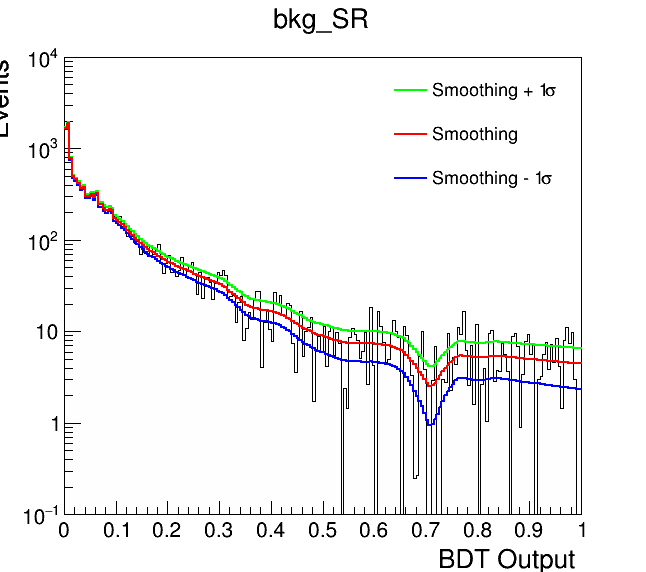

In [28]:
roohist_bkg_SB = trans2rootHist(hist_bkg_SB, bins, "bkg_SB")
roohist_bkg_SR = trans2rootHist(hist_bkg_SR, bins, "bkg_SR")
roohist_sig_SR = trans2rootHist(hist_sig_SR, bins, "sig_SR")
roohist_data_SB = trans2rootHist(hist_data_SB, bins, "data_SR")

hist_SR, hist_SR_smooth = GetHist(roohist_bkg_SR, 0.1)
hist_CR, hist_CR_smooth = GetHist(roohist_data_SB)
canv_SR = compare(hist_SR, hist_SR_smooth)
canv_SR.Draw()

# hist_CR, hist_CR_smooth = GetHist(hist_data_SB, 0.1)
# canv_CR = compare(hist_CR, hist_CR_smooth)
# canv_CR.Draw()


In [29]:
nCats = 2
partition_final = {}
significance_final = {}
output = {}
significance_all = {}

partition_final_up = {}
significance_final_up = {}
output_up = {}
significance_all_up = {}
partition_final_dn = {}
significance_final_dn = {}
output_dn = {}
significance_all_dn = {}


partition_final, significance_final, output, significance_all = getResults(roohist_sig_SR, hist_SR_smooth[0], hist_CR, nCats, nbins)

print(partition_final)
for [l,h] in partition_final:
    print([l,h])
    s = roohist_sig_SR.Integral(l, h)
    b_smooth = hist_SR_smooth[0].Integral(l, h)
    b_smooth_up = hist_SR_smooth[1].Integral(l, h)
    b_smooth_dn = hist_SR_smooth[2].Integral(l, h)
    b_nosmooth = hist_SR.Integral(l, h)

    sig5 = computeSignificance(s,b_smooth,20)
    print('significance:', sig5, 'ns:', s, 'nb smooth:', b_smooth, 'b_smooth_up:', b_smooth_up, 'b_smooth_dn:', b_smooth_dn, 'b_nosmooth:', b_nosmooth)

2  - Best categories:  0.0 0.9449999928474426 1. ---> 145.2840589265272
[[1, 189], [190, 200]]
[1, 189]
significance: 8.60827466249236 ns: 1015.97368283393 nb smooth: 13594.828198194504 b_smooth_up: 14703.719024181366 b_smooth_dn: 12485.937258183956 b_nosmooth: 13486.960243522197
[190, 200]
significance: 145.02880881225536 ns: 3241.4807068512464 nb smooth: 50.38912010192871 b_smooth_up: 73.93130588531494 b_smooth_dn: 26.8469340801239 b_nosmooth: 57.979707138161494


In [30]:
nCats = 3
partition_final = {}
significance_final = {}
output = {}
significance_all = {}

partition_final_up = {}
significance_final_up = {}
output_up = {}
significance_all_up = {}
partition_final_dn = {}
significance_final_dn = {}
output_dn = {}
significance_all_dn = {}


partition_final, significance_final, output, significance_all = getResults(roohist_sig_SR, hist_SR_smooth[0], hist_CR, nCats, nbins)

print(partition_final)
for [l,h] in partition_final:
    print([l,h])
    s = roohist_sig_SR.Integral(l, h)
    b_smooth = hist_SR_smooth[0].Integral(l, h)
    b_smooth_up = hist_SR_smooth[1].Integral(l, h)
    b_smooth_dn = hist_SR_smooth[2].Integral(l, h)
    b_nosmooth = hist_SR.Integral(l, h)

    sig5 = computeSignificance(s,b_smooth,20)
    print('significance:', sig5, 'ns:', s, 'nb smooth:', b_smooth, 'b_smooth_up:', b_smooth_up, 'b_smooth_dn:', b_smooth_dn, 'b_nosmooth:', b_nosmooth)

3  - Best categories:  0.0 0.8799999952316284 0.9700000286102295 1. ---> 151.96608947302448
[[1, 176], [177, 194], [195, 200]]
[1, 176]
significance: 4.706681270524702 ns: 551.17103645873 nb smooth: 13530.838987112045 b_smooth_up: 14610.889554977417 b_smooth_dn: 12450.788306415081 b_nosmooth: 13421.816242071252
[177, 194]
significance: 61.345902152122406 ns: 1054.6833713367355 nb smooth: 87.28861474990845 b_smooth_up: 126.92215585708618 b_smooth_dn: 47.65507245063782 b_nosmooth: 91.84208315280048
[195, 200]
significance: 138.95402041784612 ns: 2651.5999818897108 nb smooth: 27.08971643447876 b_smooth_up: 39.838619232177734 b_smooth_dn: 14.340813398361206 b_nosmooth: 31.281625436303212


In [31]:
nCats = 4
partition_final = {}
significance_final = {}
output = {}
significance_all = {}

partition_final_up = {}
significance_final_up = {}
output_up = {}
significance_all_up = {}
partition_final_dn = {}
significance_final_dn = {}
output_dn = {}
significance_all_dn = {}


partition_final, significance_final, output, significance_all = getResults(roohist_sig_SR, hist_SR_smooth[0], hist_CR, nCats, nbins)

print(partition_final)
for [l,h] in partition_final:
    print([l,h])
    s = roohist_sig_SR.Integral(l, h)
    b_smooth = hist_SR_smooth[0].Integral(l, h)
    b_smooth_up = hist_SR_smooth[1].Integral(l, h)
    b_smooth_dn = hist_SR_smooth[2].Integral(l, h)
    b_nosmooth = hist_SR.Integral(l, h)

    sig5 = computeSignificance(s,b_smooth,20)
    print('significance:', sig5, 'ns:', s, 'nb smooth:', b_smooth, 'b_smooth_up:', b_smooth_up, 'b_smooth_dn:', b_smooth_dn, 'b_nosmooth:', b_nosmooth)

4  - Best categories:  0.0 0.8450000286102295 0.949999988079071 0.9800000190734863 1. ---> 153.96349738787112
[[1, 169], [170, 190], [191, 196], [197, 200]]
[1, 169]
significance: 3.8509675652427116 ns: 449.80997642479497 nb smooth: 13494.152731180191 b_smooth_up: 14558.178534507751 b_smooth_dn: 12430.12681478262 b_nosmooth: 13383.645599828113
[170, 190]
significance: 40.57941991614289 ns: 642.6495969022725 nb smooth: 105.39118099212646 b_smooth_up: 152.42777299880981 b_smooth_dn: 58.3545880317688 b_nosmooth: 107.98743265473877
[191, 196]
significance: 73.89967637226555 ns: 1004.7960078632884 nb smooth: 27.715478897094727 b_smooth_up: 40.61077880859375 b_smooth_dn: 14.820178508758545 b_nosmooth: 40.5262449198648
[197, 200]
significance: 128.77141409513297 ns: 2160.1988084948207 nb smooth: 17.957927227020264 b_smooth_up: 26.43324375152588 b_smooth_dn: 9.482610940933228 b_nosmooth: 12.780673257637883


cat 0


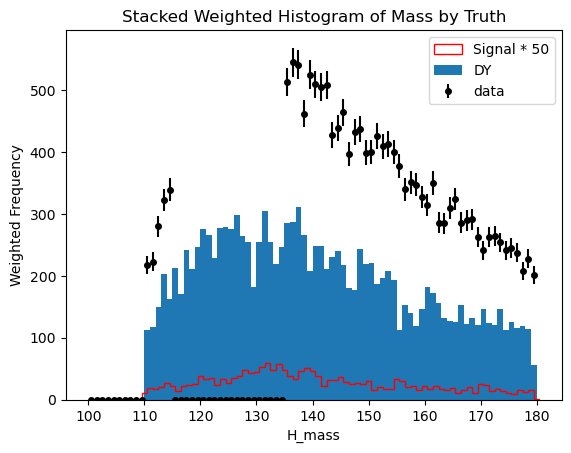

cat 1


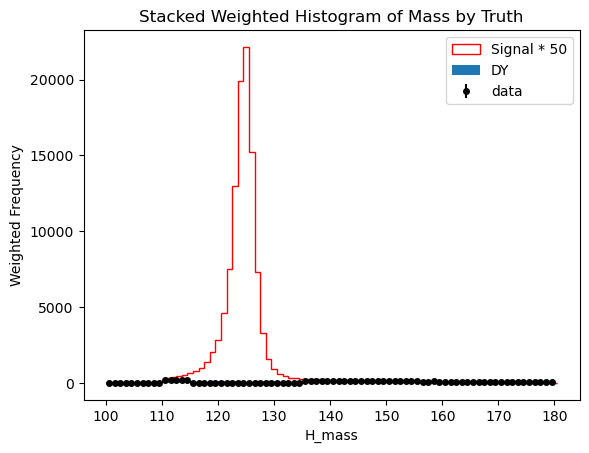

In [32]:
def draw_dataMC(var_name, BDT_low, BDT_high, nbins = 50,range_hl=(0,1)):
    hist_DY, bins = np.histogram(y_test_frame[var_name][(y_test_frame['truth']==1) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']==1) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], bins=nbins,range=range_hl)
    # hist_ZG, _ = np.histogram(y_test_frame[var_name][(y_test_frame['truth']==2) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']==2) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], bins=nbins,range=range_hl)
    #data_mass_blind = data_all_frame['H_mass'].loc[(data_all_frame['H_mass'] >= 120), 'H_mass'] = 0
    hist_data, _ = np.histogram(data_all_frame[var_name][(data_all_frame['disc']>BDT_low) & (data_all_frame['disc']<=BDT_high) & ((data_all_frame['H_mass']<115) | (data_all_frame['H_mass']>135))], bins=nbins,range=range_hl)
    hist_data_err = np.sqrt(hist_data)
    bins = bins + (bins[1]-bins[0])/2.
    # center = (bins[:-1] + bins[1:]) / 2

    # 绘制堆叠的直方图
    plt.bar(bins[:-1], hist_DY, width=np.diff(bins), label='DY')
    # plt.bar(bins[:-1], hist_ZG, width=np.diff(bins), label='ZG', bottom=hist_DY)
    plt.hist(y_test_frame[var_name][(y_test_frame['truth']<0) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']<0) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)]*50, bins=bins, histtype='step', color='r', label='Signal * 50')
    plt.errorbar(bins[:-1], hist_data, yerr=hist_data_err, fmt='.', c='black', label='data', markersize=8,capthick=0)

    plt.legend()
    plt.xlabel(var_name)
    plt.ylabel('Weighted Frequency')
    plt.title('Stacked Weighted Histogram of Mass by Truth')
    plt.show()

cats = [[0.0, 0.12999999523162842], [0.12999999523162842, 1.]]

cats[0][0]
for i in range(2):
    print('cat',i)
    draw_dataMC(var_name='H_mass', BDT_low=cats[i][0], BDT_high=cats[i][1], nbins = 80, range_hl=(100,180))

cat 0


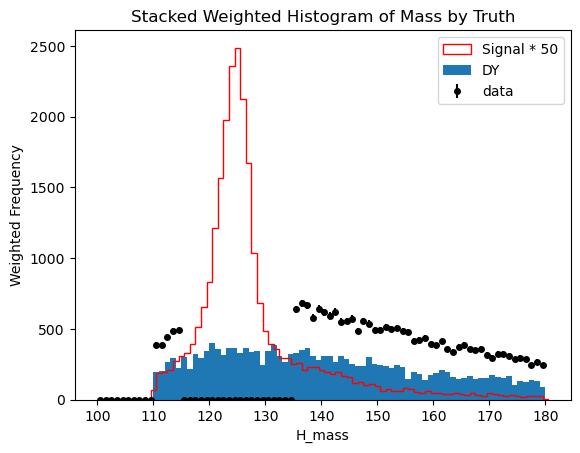

cat 1


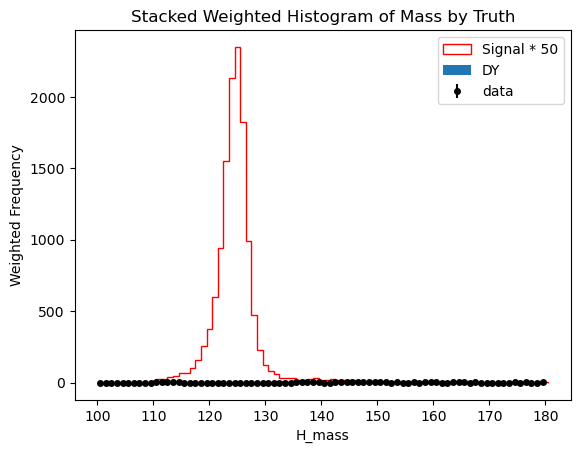

cat 2


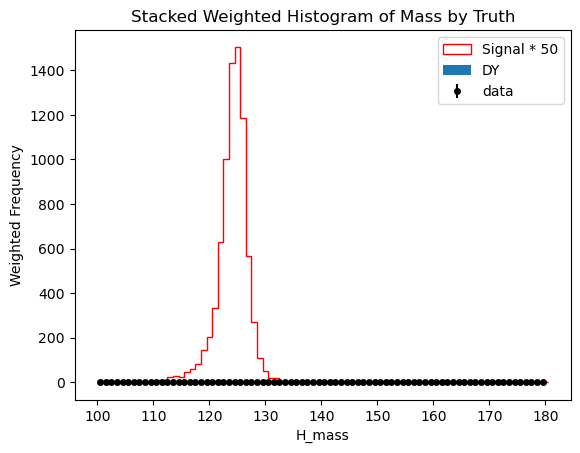

cat 3


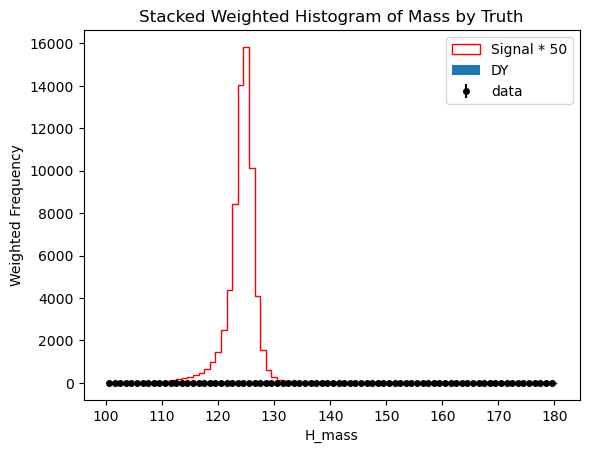

In [33]:
def draw_dataMC(var_name, BDT_low, BDT_high, nbins = 50,range_hl=(0,1)):
    hist_DY, bins = np.histogram(y_test_frame[var_name][(y_test_frame['truth']==1) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']==1) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], bins=nbins,range=range_hl)
    # hist_ZG, _ = np.histogram(y_test_frame[var_name][(y_test_frame['truth']==2) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']==2) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], bins=nbins,range=range_hl)
    #data_mass_blind = data_all_frame['H_mass'].loc[(data_all_frame['H_mass'] >= 120), 'H_mass'] = 0
    hist_data, _ = np.histogram(data_all_frame[var_name][(data_all_frame['disc']>BDT_low) & (data_all_frame['disc']<=BDT_high) & ((data_all_frame['H_mass']<115) | (data_all_frame['H_mass']>135))], bins=nbins,range=range_hl)
    hist_data_err = np.sqrt(hist_data)
    bins = bins + (bins[1]-bins[0])/2.
    # center = (bins[:-1] + bins[1:]) / 2

    # 绘制堆叠的直方图
    plt.bar(bins[:-1], hist_DY, width=np.diff(bins), label='DY')
    # plt.bar(bins[:-1], hist_ZG, width=np.diff(bins), label='ZG', bottom=hist_DY)
    plt.hist(y_test_frame[var_name][(y_test_frame['truth']<0) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']<0) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)]*50, bins=bins, histtype='step', color='r', label='Signal * 50')
    plt.errorbar(bins[:-1], hist_data, yerr=hist_data_err, fmt='.', c='black', label='data', markersize=8,capthick=0)

    plt.legend()
    plt.xlabel(var_name)
    plt.ylabel('Weighted Frequency')
    plt.title('Stacked Weighted Histogram of Mass by Truth')
    plt.show()

cats = [[0.0, 0.925000011920929], [0.925000011920929, 0.9599999785423279], [0.9599999785423279, 0.9700000286102295], [0.9700000286102295, 1.]]

cats[0][0]
for i in range(4):
    print('cat',i)
    draw_dataMC(var_name='H_mass', BDT_low=cats[i][0], BDT_high=cats[i][1], nbins = 80, range_hl=(100,180))

# Optimization of MVA Cut Point by Significance - Run 2

In [34]:
dfs = {}
tree = {}
for year in years:
    dfs[year] = {}
    tree[year] = {}
    for dataset in bkg_name + data_name:
        dfs[year][dataset], tree[year][dataset] = convert_ntuple_dataframe("{}/{}/".format(file_path,dataset),"{}_{}.root".format(tree_name, year), tree_name, variables+mass_variables+wt_variables, selections="H_m>110 && H_m<180")
        dfs[year][dataset]['mass'] = list(random.choice(mass_list) for _ in range(dfs[year][dataset].shape[0]))
        dfs[year][dataset]['param'] = (dfs[year][dataset]['ALP_m'] - dfs[year][dataset]['mass']) / dfs[year][dataset]['H_m']

    for dataset in sig_name:
        dfs[year][dataset] = {}
        tree[year][dataset] = {}
        for mass in mass_list:
            dfs[year][dataset][mass], tree[year][dataset][mass] = convert_ntuple_dataframe("{}/{}/".format(file_path, dataset), 'ALP_M'+str(int(mass))+'.root', tree_name, variables+mass_variables+wt_variables, selections="H_m>110 && H_m<180")
            dfs[year][dataset][mass]["mass"] = mass
            dfs[year][dataset][mass]['param'] = (dfs[year][dataset][mass]['ALP_m'] - dfs[year][dataset][mass]['mass']) / dfs[year][dataset][mass]['H_m']
            # dfs[year][dataset]['factor'] = dfs[year][dataset]['factor'] * dfs[year][dataset]['pho1SFs'] * dfs[year][dataset]['pho2SFs'] 



df_bkg_dy   = pd.concat([dfs[y]["DYJets"] for y in years])
df_bkg_all  = pd.concat([dfs[y][bkg] for y in years for bkg in bkg_name ])

df_sig_a    = pd.concat([dfs[y]["sig"][m] for y in years for m in mass_list])
df_sig_all  = pd.concat([dfs[y][sig][m] for y in years for sig in sig_name for m in mass_list])

df_data_all = pd.concat([dfs[y][dataset] for y in years for dataset in data_name])


var_indices = [df_sig_all.columns.get_loc(v) for v in variables+['param']] # get positions of all the variables set above
mass_var_indices = [df_sig_all.columns.get_loc(v) for v in mass_variables]
wt_var_indices = [df_sig_all.columns.get_loc(v) for v in wt_variables]
# cat_var_indices = [df_sig_all.columns.get_loc(v) for v in rewt_variables]

signal_a = df_sig_a.values
signal = df_sig_all.values
# signal_VBF = df_sig_VBF.values
background_DY = df_bkg_dy.values
background = df_bkg_all.values

# background_ZG = df_bkg_ZG.values

#signal label as 1, bkg label as 0 (ground truth)
sig_label_a = np.ones(len(signal_a))
# sig_label_VBF = np.ones(len(signal_VBF))
bkg_label_DY = np.zeros(len(background_DY))
# bkg_label_ZG = np.zeros(len(background_ZG))

sig_proc_a = -1*np.ones(len(signal_a))
# sig_proc_VBF = -2*np.ones(len(signal_VBF))
bkg_proc_DY = np.ones(len(background_DY))
# bkg_proc_ZG = 2*np.ones(len(background_ZG))

x = np.concatenate((signal_a, background_DY))
y = np.concatenate((sig_label_a, bkg_label_DY))
z = np.concatenate((sig_proc_a, bkg_proc_DY))

print("Number of signal MC events:",len(signal))
print("Number of background MC events:",len(background))
print("Number of background DY MC events:",len(background_DY))
# print("Number of background ZG MC events:",len(background_ZG))

nsigw = np.sum(signal[:,wt_var_indices])
nbkgw = np.sum(background[:,wt_var_indices])
nbkgw_DY = np.sum(background_DY[:,wt_var_indices])
# nbkgw_ZG = np.sum(background_ZG[:,wt_var_indices])
#nbkgw_TT = np.sum(background_TT[:,wt_var_indices])

print("expected number of events for signal: ")
print(nsigw)
print("expected number of events for all bkg: ")
print(nbkgw)
print("expected number of events for DY bkg: ")
print(nbkgw_DY)
# print("expected number of events for ZG bkg: ")
# print(nbkgw_ZG)


sig = len(signal)
bkg = len(background)
total = bkg + sig
print('Raw events:\n    Total: {}\n    Signal: {} ({:.2f}% of total)\n    Background: {} ({:.2f}% of total)\n'.format(total, sig, 100 * sig / total, bkg, 100 * bkg / total))
weight_for_0 = (1.0 / bkg)*(total)/2.0
weight_for_1 = (1.0 / sig)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class background: {:.2f}'.format(weight_for_0))
print('Weight for class signal: {:.2f}'.format(weight_for_1))
scale_weight = (1.0*bkg)/(sig*1.0)
print('scale weight : {:.2f}'.format(scale_weight))


data_all_reduced = df_data_all.to_numpy()[:,var_indices]
data_all_w = df_data_all.to_numpy()[:,wt_var_indices].flatten()
data_all_mass = df_data_all.to_numpy()[:,Hm_var_indices].flatten()
# data_all_cats = df_data_all.to_numpy()[:,cat_var_indices]
data_all_pred = model.predict_proba(data_all_reduced)[:, 1]
data_all_frame = pd.DataFrame({'truth':None, 'disc':data_all_pred, 'label':None, 'weight':data_all_w, 'H_mass':data_all_mass})


x_reduced = x[:,var_indices]
x_w = x[:,wt_var_indices].flatten()
x_mass = x[:,Hm_var_indices].flatten()
x_pred = model.predict_proba(x_reduced)[:, 1]
# x_cats = x[:,cat_var_indices]
y_test_frame = pd.DataFrame({'truth':z, 'disc':x_pred, 'label':y, 'weight':x_w, 'H_mass':x_mass})

print( x_reduced[0] )
print(f"predict test: {model.predict_proba([x_reduced[0]])}")

data = data_all_frame
bkg = y_test_frame[(y_test_frame['truth'] > 0)]
bkg_DY = y_test_frame[(y_test_frame['truth'] == 1 )]
# bkg_ZG = y_test_frame[(y_test_frame['truth'] == 2)]
# bkg_TT = y_test_frame[(y_test_frame['truth'] == 3)]
sig = y_test_frame[(y_test_frame['truth'] < 0)]

Number of signal MC events: 245591
Number of background MC events: 23169
Number of background DY MC events: 23169
expected number of events for signal: 
4527.525456914849
expected number of events for all bkg: 
34549.54691844785
expected number of events for DY bkg: 
34549.54691844785
Raw events:
    Total: 268760
    Signal: 245591 (91.38% of total)
    Background: 23169 (8.62% of total)

Weight for class background: 5.80
Weight for class signal: 0.55
scale weight : 0.09
[2.14741611e+01 9.89748716e-01 1.04567138e-02 1.03421974e+01
 1.16510029e+01 9.80397582e-01 1.22568235e-02 2.09069195e+01
 0.00000000e+00 1.71409714e+00 6.41746148e-02 1.71229875e+00
 2.65530109e-01 3.30871162e+01 1.21947311e-04]
predict test: [[0.03541058 0.9645894 ]]


Error in <THashList::Delete>: A list is accessing an object (0x1472e080) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0xf45f380) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0xc65eb90) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0xc660a30) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0xc6649e0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x240a31c0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x1d2a8d50) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0xf465a80) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x26b6b080) already deleted (list name =

In [35]:
##########################################################
# get transfered discriminator
##########################################################

def getDiscriminator_hist(frame, boundaries, bins, name, region="all"):
    hist_root = TH1D(name, name, len(bins) - 1, bins)
    hist_list = []

    for i in range(len(bins) - 1):
        low = boundaries[i]
        heigh = boundaries[i+1]
        
        if region == "SR":
            nEvents = sum(frame['weight'][(frame['disc']>low) & (frame['disc']<=heigh) & (frame['H_mass']>115) & (frame['H_mass']<135)])
        elif region == "SB":
            nEvents = sum(frame['weight'][(frame['disc']>low) & (frame['disc']<=heigh) & ((frame['H_mass']<115) | (frame['H_mass']>135))])
        else:
            nEvents = sum(frame['weight'][(frame['disc']>low) & (frame['disc']<=heigh)])

        hist_root.SetBinContent(i + 1, nEvents)
        hist_list.append(nEvents)

        #print("nEvents", nEvents, 'bins', bins[i], 'low/heigh', low, '/', heigh)

    return hist_root, np.array(hist_list)

##########################################################
# make ROC curve
##########################################################

fpr_test, tpr_test, boundary_test = roc_curve(y_test_frame['label'].values, y_test_frame['disc'].values, sample_weight=y_test_frame['weight'].values)

######################################

nbins = 100
sig_effs = np.array( [round((i+1)*(1.0/nbins), 3) for i in range(nbins)] )

boundaries = np.array([]).astype(float)

for sig_eff in sig_effs:
    sig_effs_norm = abs(tpr_test-sig_eff)
    index = np.where(sig_effs_norm == min(sig_effs_norm))[0][0]
    if sig_eff == sig_effs[-1]:
        boundaries = np.insert(boundaries, 0, 0)
    else:
        boundaries = np.insert(boundaries, 0, boundary_test[index])
    #boundaries.append(boundary_test[index])

sig_effs = np.insert(sig_effs, 0, 0.0)
BDT_boundaries = np.append(boundaries, 1.0)

In [36]:
len(BDT_boundaries)

101

In [37]:
hist_bkg_root, hist_bkg = getDiscriminator_hist(bkg, BDT_boundaries, sig_effs, 'bkg', region="SR")
hist_sig_root, hist_sig = getDiscriminator_hist(sig, BDT_boundaries, sig_effs, 'sig', region="SR")
hist_data_root, hist_data = getDiscriminator_hist(data, BDT_boundaries, sig_effs, 'data', region="SB")
hist_bkg_DY_root, hist_bkg_DY = getDiscriminator_hist(bkg_DY, BDT_boundaries, sig_effs, 'bkg_DY', region="all")
# hist_bkg_ZG_root, hist_bkg_ZG = getDiscriminator_hist(bkg_ZG, BDT_boundaries, sig_effs, 'bkg_ZG', region="all")

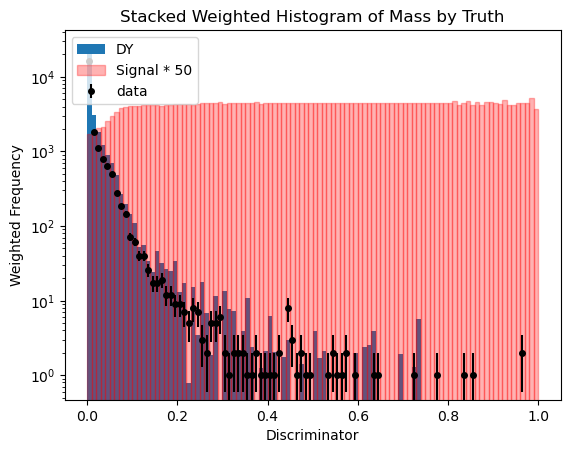

In [38]:
weidth = sig_effs[1]-sig_effs[0]
bins = sig_effs + weidth/2.
hist_data_err = np.sqrt(hist_data)
center = (bins[:-1] + bins[1:]) / 2

# 绘制堆叠的直方图
plt.bar(bins[:-1], hist_bkg_DY, width=np.diff(bins), label='DY')
# plt.bar(bins[:-1], hist_bkg_ZG, width=np.diff(bins), label='ZG', bottom=hist_bkg_DY)
plt.bar(bins[:-1], hist_sig*100, width=np.diff(bins), color='red', edgecolor='red', label='Signal * 50', alpha=0.3)
#plt.bar(bins[:-1], hist_bkg_TT, width=np.diff(bins), label='TT', bottom=hist_bkg_DY)
plt.errorbar(bins[:-1], hist_data, yerr=hist_data_err, fmt='.', c='black', label='data', markersize=8,capthick=0)

plt.legend()
plt.xlabel("Discriminator")
plt.ylabel('Weighted Frequency')
plt.title('Stacked Weighted Histogram of Mass by Truth')
plt.yscale('log')
plt.show()

/afs/cern.ch/user/p/pelai/.conda/envs/python_Three/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:

invalid value encountered in true_divide



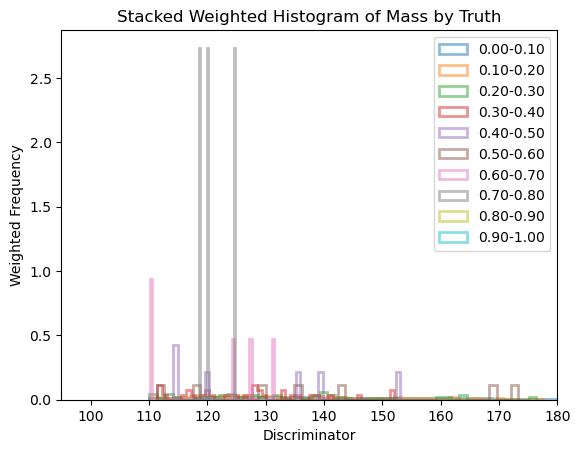

In [39]:
n_bdt_bin = 10
nbins = 50
range_hl = (95, 180)
w = int((len(BDT_boundaries)-1)/n_bdt_bin)

for i in range(n_bdt_bin):
    low = BDT_boundaries[(i)*w]
    heigh = BDT_boundaries[(i+1)*w]
    eff_low = sig_effs[(i)*w]
    eff_heigh = sig_effs[(i+1)*w]
    
    bkg_mc = bkg[ (bkg['disc'] > low) & (bkg['disc'] <= heigh) ]

    plt.hist(bkg_mc["H_mass"], bins=nbins, histtype='step', linewidth=2, density=True, alpha=0.5, label="%.2f-%.2f" % (eff_low, eff_heigh))
    plt.legend()
    plt.xlabel("Discriminator")
    plt.ylabel('Weighted Frequency')
    plt.title('Stacked Weighted Histogram of Mass by Truth')
    
# Set the x-axis range
plt.xlim(range_hl)

plt.show()
#canv.Draw()

In [40]:
from itertools import combinations

boundaries_test = sig_effs[::4][1:-1]
boundaries_number = len(boundaries_test)

nCats = 2

#print(list(list(combinations(boundaries_test, 2))[6]))#.insert(0, 0.))
#print(hist_bkg[0:2])
#index = np.where(sig_effs == boundaries_test[5])[0]

for nCats in range(4):

    boundaries_all = list(combinations(boundaries_test, nCats+1))

    #print(boundaries_all)

    significance_best = 0.0
    significance_best_lists = []
    boundaries_best = np.array([])

    for boundaries in boundaries_all:

        boundaries = np.array(boundaries)
        boundaries = np.insert(boundaries, 0, 0.)
        boundaries = np.append(boundaries, 1.0)
        
        #print(boundaries)
        significance_sum = 0.0
        significance_lists = []

        for i in range(len(boundaries)-1):
            index_low = np.where(sig_effs == boundaries[i])[0][0]
            index_heigh = np.where(sig_effs == boundaries[i+1])[0][0]

            # remove the lowest BDT bin
            if index_low == 0: continue

            nbkg = sum(hist_bkg[index_low:index_heigh-1])
            nsig = sum(hist_sig[index_low:index_heigh-1])

            #print("index_low",index_low, "index_heigh", index_heigh, "nbkg", nbkg, "nsig", nsig, "ndata", sum(hist_data[index_low:index_heigh-1]))

            if nbkg > 0:
                significance = nsig/np.sqrt(nbkg)
            if nbkg == 0:
                significance = nsig/np.sqrt(1.)

            significance_sum = np.sqrt(significance_sum*significance_sum + significance*significance)
            significance_lists.append(significance)

        if significance_sum > significance_best:
            significance_best = significance_sum
            significance_best_lists = significance_lists
            boundaries_best = boundaries
        

    print("nCats:", nCats+2, ", max significance:", significance_best, ", Boundaries:", boundaries_best, "Significance list:", significance_best_lists)


nCats: 2 , max significance: 1032.4709808656519 , Boundaries: [0.   0.76 1.  ] Significance list: [1032.4709808656519]
nCats: 3 , max significance: 1110.420471239864 , Boundaries: [0.   0.36 0.76 1.  ] Significance list: [408.70196551873846, 1032.4709808656519]
nCats: 4 , max significance: 1370.021414892208 , Boundaries: [0.   0.44 0.56 0.8  1.  ] Significance list: [1032.4709808656519, 286.1798663958465, 853.852115417665]
nCats: 5 , max significance: 1373.38029803972 , Boundaries: [0.   0.44 0.56 0.64 0.8  1.  ] Significance list: [1032.4709808656519, 201.16135379003666, 225.05064197225974, 853.852115417665]


BDT_low/BDT_high: 0.8005678653717041 0.9738442897796631


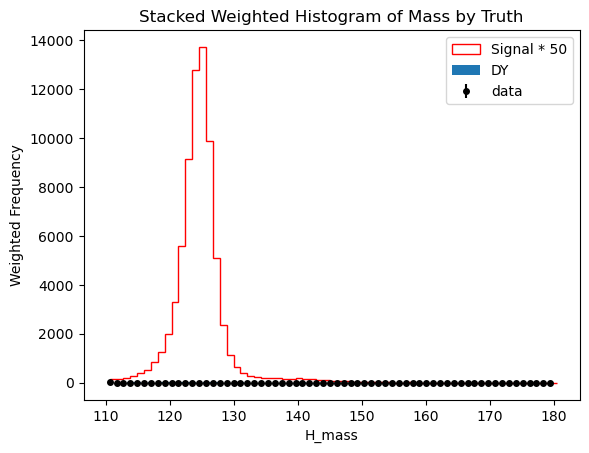

BDT_low/BDT_high: 0.9738442897796631 0.982675313949585


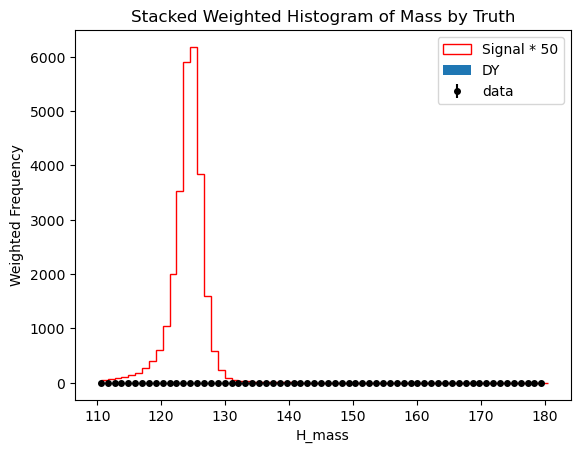

BDT_low/BDT_high: 0.982675313949585 0.9864093065261841


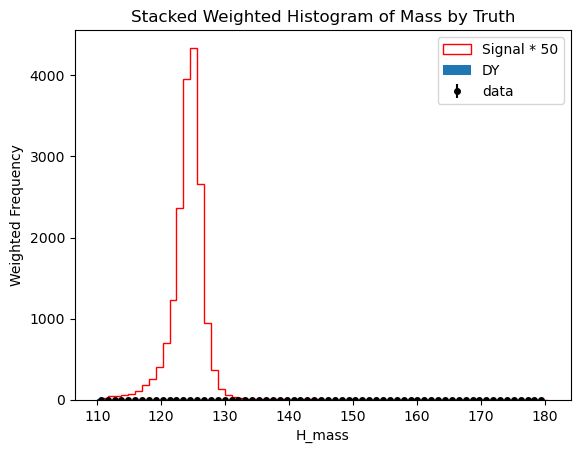

In [41]:
def draw_dataMC(var_name, BDT_low, BDT_high, nbins = 50, range_hl=(0,1)):
    hist_DY, bins = np.histogram(y_test_frame[var_name][(y_test_frame['truth']==1) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']==1) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], bins=nbins,range=range_hl)
    # hist_ZG, _ = np.histogram(y_test_frame[var_name][(y_test_frame['truth']==2) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']==2) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], bins=nbins,range=range_hl)
    #data_mass_blind = data_all_frame['H_mass'].loc[(data_all_frame['H_mass'] >= 120), 'H_mass'] = 0
    hist_data, _ = np.histogram(data_all_frame[var_name][(data_all_frame['disc']>BDT_low) & (data_all_frame['disc']<=BDT_high) & ((data_all_frame['H_mass']<115) | (data_all_frame['H_mass']>135))], bins=nbins,range=range_hl)
    hist_data_err = np.sqrt(hist_data)
    bins = bins + (bins[1]-bins[0])/2.
    # center = (bins[:-1] + bins[1:]) / 2.

    # 绘制堆叠的直方图
    plt.bar(bins[:-1], hist_DY, width=np.diff(bins), label='DY')
    plt.hist(y_test_frame[var_name][(y_test_frame['truth']<0) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)], weights=y_test_frame['weight'][(y_test_frame['truth']<0) & (y_test_frame['disc']>BDT_low) & (y_test_frame['disc']<=BDT_high)]*50, bins=bins, histtype='step', color='r', label='Signal * 50')
    plt.errorbar(bins[:-1], hist_data, yerr=hist_data_err, fmt='.', c='black', label='data', markersize=8,capthick=0)

    plt.legend()
    plt.xlabel(var_name)
    plt.ylabel('Weighted Frequency')
    plt.title('Stacked Weighted Histogram of Mass by Truth')
    plt.show()

boundaries_best = [ 0., 0.12, 0.44, 0.56, 0.64, 1. ]
nCats = 3
BDT_boundaries_best = []
for b in boundaries_best:
    BDT_boundaries_best.append(BDT_boundaries[np.where(sig_effs == b)[0][0]])
#BDT_boundaries_best

for i in range(nCats):
    BDT_low = BDT_boundaries_best[i+1]
    BDT_high = BDT_boundaries_best[i+2]

    print("BDT_low/BDT_high:", BDT_low, BDT_high)
    draw_dataMC("H_mass", BDT_low, BDT_high, 65, (110,180))
